# Промышленность. Исследовательский анализ. План проекта

Импортируем необходимые библиотеки.

In [387]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from sklearn.ensemble import IsolationForest, RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, r2_score as r2, mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from scipy.stats import loguniform, uniform

from lightgbm import LGBMRegressor

## Загрузка данных и ознакомление

В нашем распоряжении 7 файлов, описывающих разные этапы промышленного процесса. Загрузим их и проведем первичный осмотр данных.

### Электроды

Электроды установлены в крышке ковша и используются для подогрева расплавленной стали.

In [2]:
df_arc = pd.read_csv('data/data_arc.csv')
df_bulk = pd.read_csv('data/data_bulk.csv')
df_bulk_time = pd.read_csv('data/data_bulk_time.csv')
df_gas = pd.read_csv('data/data_gas.csv')
df_temp = pd.read_csv('data/data_temp.csv')
df_wire = pd.read_csv('data/data_wire.csv')
df_wire_time = pd.read_csv('data/data_wire_time.csv')

In [4]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [5]:
df_arc.tail(7)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


In [6]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


- В нашем распоряжении информация о 3241 партии (известно по полю *key*).
- В данных 14876 строк или же итераций нагрева. Пропуски отсутствуют.
- Имеются данные о времени нагрева (момент начала и конца работы электрода). По нескольким строкам видно, что это несколько минут.
- Также имеется информация о двух составляющих мощности.

### Объем подачи сыпучих материалов

Сыпучие материалы подаются из бункера для легирования стали.

In [8]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [9]:
df_bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [10]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


- В нашем распоряжении 16 столбцов и 3129 строк.
- Каждая строка хранит информацию о номере партии, однако самих партий больше, чем строк в датасете (3241 против 3129), значит пропущены данные о 112 партиях.
- Не совсем понятно, что содержат столбцы. Возможно это масса подаваемых в сплав различных веществ, это нужно уточнить.
- В данных довольно много пропусков.

### Время подачи сыпучих материалов

In [12]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [13]:
df_bulk_time.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


In [14]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


- Как и в случае с объемом сыпучих веществ, имеем 3129 строку и 16 столбцов. 
- В данных имеется много пропусков, а в непропущенных ячейках находится время. Скорее всего, это момент подачи сыпучих материалов в сплав. Если посмотреть на первую партию, то видно, что время подачи происходит в момент работы электродов.

### Продувка сплава газом

После подачи в сплав легирующих материалов, его продувают инертным газом.

In [16]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [17]:
df_gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [18]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


- В нашем распоряжении 3239 строк и 2 столбца. Пропуски отсутствуют.
- Каждая строка содержит информацию об одной партии сплава.
- Не совсем понятно, что находится в столбце *Газ 1*, возможно объем или расход газа, используемого для продувки.
- Стоит отметить, что количество строк меньше количества партий (3239 против 3241), что говорит о том, что для 2 партий нет информации о продувке газом.

### Температура

Температура является целевым признаком в данной задаче. Ее измеряют для достижения оптимальной температуры плавки.

In [20]:
df_temp.head(7)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0


In [21]:
df_temp.tail(7)

,key,Время замера,Температура
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [22]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [23]:
(df_temp.isna().sum() / len(df_temp)).to_frame()

,0
key,0.000000
Время замера,0.000000
Температура,0.182373


- В нашем распоряжении 15907 строк и 3 столбца.
- В данных имеются пропуски. Похоже, что это те пропуски, которые нам нужно уметь предсказывать.
- Если посмотреть на время замера и время работы электродов из первой таблицы, можно заключить, что замер температуры производится в момент, когда электроды выключены.

### Объем подачи проволочных материалов

Проволока (как и сыпучие материалы) подается в сплав дял легирования. 

In [25]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_wire.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


- В нашем распоряжении 10 столбцов и 3081 строка.
- Каждая строка хранит информацию о номере партии, однако самих партий больше, чем строк в датасете (3241 против 3081), значит пропущены данные о 160 партиях. Возможно в эти партии проволока попросту не подавалась.
- Столбцы скорее всего содержут массу различных веществ, подаваемых в сплав в виде проволоки.
- В данных довольно много пропусков.

### Время подачи проволочных материалов

In [29]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_wire_time.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


- Имеем то же количество строк и столбцов, что и в данных об объеме подачи проволоки. 3081 строка и 10 столбцов.
- Пропуски также совпадают. 
- Можем предположить, что если значение не пропущено, значит данную проволоку в отмеченный момент времени подавали в сплав.
- Если обратиться к таблице по электродам, видно, что проволока подается в моменты, когда электроды выключены.

### Вывод

Весь процесс обработки стали можно разделить на 5 фаз: нагрев сплава электродами, подача сыпучих материалов для легирования, подача проволоки, продувка сплава инертным газом и измерение температуры. По первичному осмотру можно сделать следующие предположения:
- Подача сыпучих материалов производится в момент работы электродов;
- Подача проволоки и измерение температуры производится в момент, когда электроды отключены.

Стоит обратить внимание на следующие моменты и уточнить их у заказчика:
- Для некоторых партий нет информации о подаче проволоки или сыпучих материалов. Можем ли мы считать, что в этих партиях не осуществлялась подача?
- Что за величину содержат столбцы таблицы об объеме подачи сыпучих материалов и проволоки? Скорее всего это обьем того или ного вещества.
- Какая величина содержится в поле *Газ 1* таблицы о продувке? В чем она измеряется? И как осуществляется продувка: один раз или постоянно на протяжении обработки партии?
- В таблице температуры имеются пропуски. Как я понимаю, данные моменты времени мы должны считать за тестовую выборку?

**Главный вопрос**: как я понимаю, мы должны уметь предсказывать температуру сплава в любой момент времени, учитывая, сколько легирующих элементов уже поступило в него, сколько энергии было вложено электродами, а также сколько газа было использовано для продувки. Верно ли утверждение?

## Исследовательский анализ данных

Рассмотрим каждую фазу обработки отдельно.

### Нагрев электродами

In [32]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Для начала переведем дату в формат даты-времени.

In [33]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

Создадим столбец, который будет содержать интервал времени нагрева дугой.

In [34]:
def make_interval(row):
    return pd.Interval(row['Начало нагрева дугой'], row['Конец нагрева дугой'], closed='both')

In [35]:
df_arc['interval'] = df_arc.progress_apply(make_interval, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 14876/14876 [00:00<00:00, 53116.68it/s]


Создадим столбец, содержащий продолжительность нагрева в секундах.

In [36]:
df_arc['duration'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']).dt.seconds

In [37]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,interval,duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,"[2019-05-03 11:02:14, 2019-05-03 11:06:02]",228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,"[2019-05-03 11:07:28, 2019-05-03 11:10:33]",185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,"[2019-05-03 11:11:44, 2019-05-03 11:14:36]",172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,"[2019-05-03 11:18:14, 2019-05-03 11:24:19]",365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,"[2019-05-03 11:26:09, 2019-05-03 11:28:37]",148


In [38]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype                         
---  ------                --------------  -----                         
 0   key                   14876 non-null  int64                         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]                
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]                
 3   Активная мощность     14876 non-null  float64                       
 4   Реактивная мощность   14876 non-null  float64                       
 5   interval              14876 non-null  interval[datetime64[ns], both]
 6   duration              14876 non-null  int64                         
dtypes: datetime64[ns](2), float64(2), int64(2), interval(1)
memory usage: 929.9 KB


Теперь можем посмотреть на распределение мощностей.

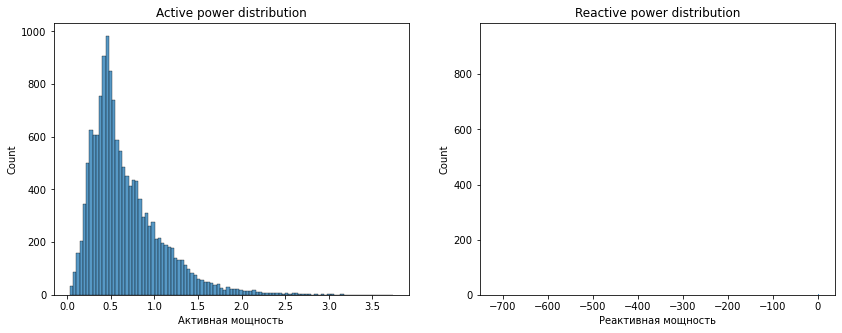

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(df_arc['Активная мощность'], ax=axes[0])
axes[0].set_title('Active power distribution')
sns.histplot(df_arc['Реактивная мощность'], ax=axes[1])
axes[1].set_title('Reactive power distribution')
plt.show()

- Распределение активной мощности имеет нормальный вид, однако распределение скошено вправо. Активная мощность лежит в диапазоне до 4. Наиболее частое значение - 0.5
- График распределения реактивной мощности выглядит странным. Скорее всего имеем дело с выбросами, проверим.

In [40]:
df_arc.describe(datetime_is_numeric=True)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,duration
count,14876.000000,14876,14876,14876.000000,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592,171.670946
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924,11.000000
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991,107.000000
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962,147.000000
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371,214.000000
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388,907.000000
std,934.571502,NaN,NaN,0.408159,5.878702,98.186803


Значения реактивной мощности должны быть в диапазоне от 0 до 2.7. Имеем явный выбор - значение -715, посмотрим на все точки, имеющие отрицательную мощность.

Стоит отметить, что даты корректны. Все даты принадлежат 2019 году.

In [41]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,interval,duration
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,"[2019-07-24 00:44:48, 2019-07-24 00:46:37]",109


Скорее всего произошла ошибка в записи, данную строку лучше просто выбросить.

In [42]:
df_arc_eda = df_arc[df_arc['Реактивная мощность'] >= 0]

Снова посмотрим на распределения.

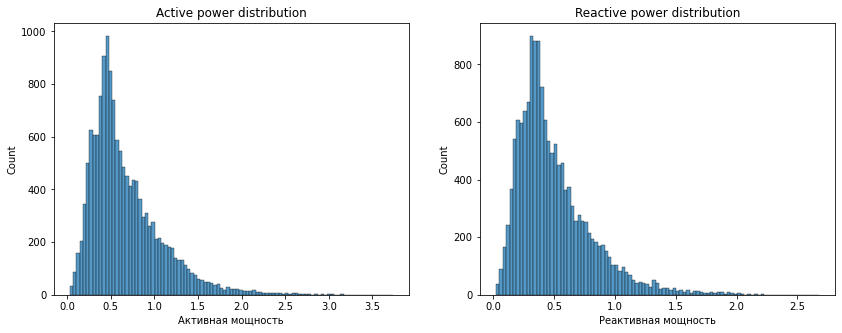

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(df_arc_eda['Активная мощность'], ax=axes[0])
axes[0].set_title('Active power distribution')
sns.histplot(df_arc_eda['Реактивная мощность'], ax=axes[1])
axes[1].set_title('Reactive power distribution')
plt.show()

Теперь все в порядке. Реактивная мощность имеет похожее распределение, что и активная мощность.

Теперь посмотрим на продолжительность нагрева.

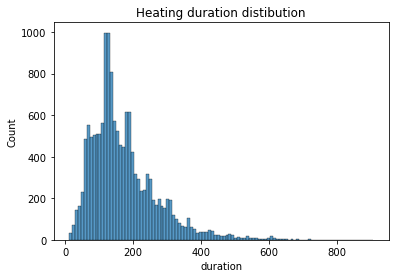

In [44]:
sns.histplot(df_arc_eda['duration'])
plt.title('Heating duration distibution')
plt.show()

- Распределение имеет нормальный вид, однако скошено вправо. 
- Наиболее частая продолжительность нагрева лежит в районе 145-170 секунд.

Посмотрим, как связаны мощности, а также продолжительность нагрева.

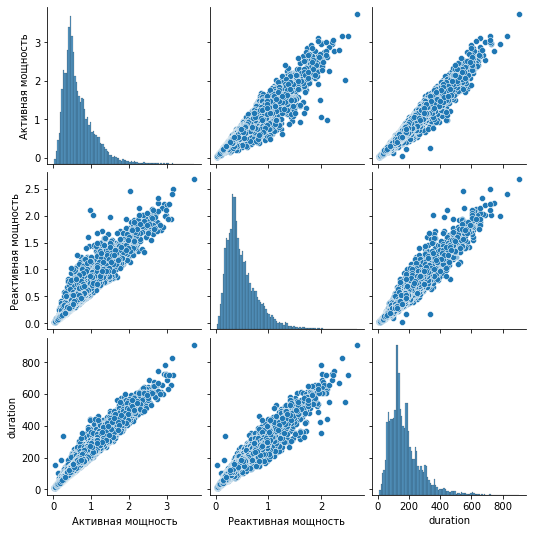

In [45]:
sns.pairplot(df_arc_eda[['Активная мощность', 'Реактивная мощность', 'duration']])
plt.show()

Все три величины имеют сильную линейную корреляцию. Имеет смысл создать переменную, характеризующую количество переданной сплаву энергии (произведение активной мощности на продолжительность нагрева).

In [46]:
df_arc['energy'] = df_arc['Активная мощность'] * df_arc['duration']

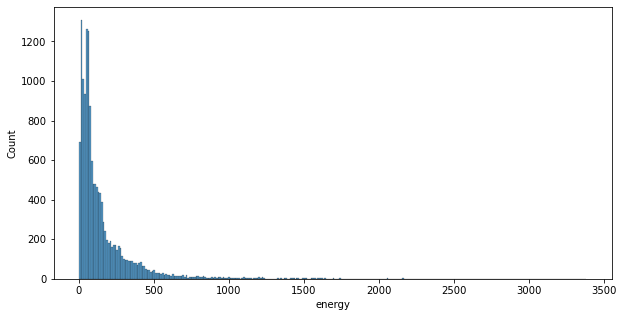

In [47]:
plt.figure(figsize=(10,5))
sns.histplot(df_arc['energy'])
plt.show()

Данное распределение имеет крайне тяжелый хвост. Нужно уточнить у тимлида, стоит ли использовать такую фичу.

### Подача сыпучих материалов

In [48]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Проверять 15 распределений с помощью графиков довольно сложно. Куда проще вызвать метод .describe() и посмотреть на медианы, средние, максимальные и минимальные значения.

In [49]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Выделяются *Bulk 1*, *Bulk 3*, *Bulk 12* и *Bulk 15*. Посмотрим на их распределения.

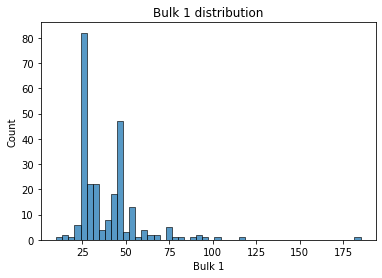

In [50]:
sns.histplot(df_bulk['Bulk 1'], bins=50)
plt.title('Bulk 1 distribution')
plt.show()

Отчетливо видны выбросы справа.

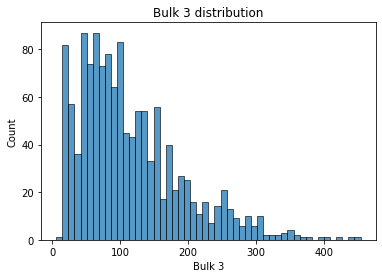

In [51]:
sns.histplot(df_bulk['Bulk 3'], bins=50)
plt.title('Bulk 3 distribution')
plt.show()

В целом распределение выглядит адекватно, однако одно минимальное значение все же выбивается.

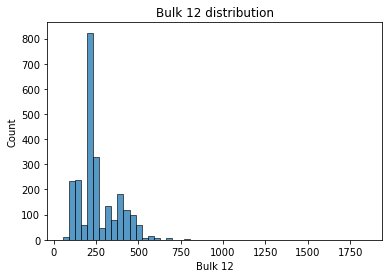

In [52]:
sns.histplot(df_bulk['Bulk 12'], bins=50)
plt.title('Bulk 12 distribution')
plt.show()

Здесь же отчетливо видно, что присутствуют большие выбросы.

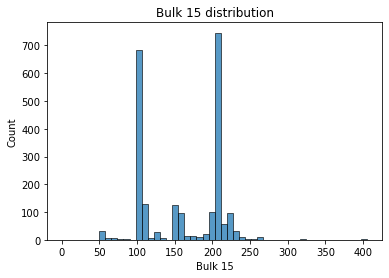

In [53]:
sns.histplot(df_bulk['Bulk 15'], bins=50)
plt.title('Bulk 15 distribution')
plt.show()

Здесь же есть как очень высокие, так и очень низкие значения. 

Для каждого столбца нужно уточнить, в каких диапазонах должны лежать объемы сыпучих материалов.

Перейдем к рассмотрению времени загрузки.

In [54]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Здесь нужно проверить, лежат ли все даты в нашем диапазоне.

Переведем дату в формат даты-времени.

In [55]:
for el in [col for col in df_bulk_time.columns if col != 'key']:
    df_bulk_time[el] = pd.to_datetime(df_bulk_time[el])

In [56]:
df_bulk_time.describe(datetime_is_numeric=True)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-27 08:32:26.031746048,2019-07-09 02:04:44.545454336,2019-07-05 14:02:19.653312768,2019-06-30 17:27:38.687376896,2019-07-10 12:23:28.623376640,2019-07-03 15:57:30.003472384,2019-07-23 21:38:41.040000,2019-07-05 17:46:11,2019-06-21 00:53:43.157894912,2019-07-04 02:03:09.647727616,2019-07-11 23:35:46.310734336,2019-07-03 02:04:28.317142784,2019-06-29 02:00:06.722222336,2019-07-03 10:03:08.939059200,2019-07-03 16:07:21.480871936
min,1.000000,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
25%,816.000000,2019-05-28 02:36:05.750000128,2019-05-26 21:24:43.249999872,2019-06-06 08:39:05.500000,2019-05-29 08:23:05.750000128,2019-06-17 19:42:11,2019-06-05 04:40:07,2019-07-17 11:25:12,2019-07-05 17:46:11,2019-05-14 02:37:23.500000,2019-05-31 15:29:27.500000,2019-06-12 19:24:37,2019-06-01 23:11:18,2019-05-27 22:41:40.750000128,2019-06-02 12:09:03.249999872,2019-06-02 18:47:20.249999872
50%,1622.000000,2019-06-23 02:31:45.500000,2019-07-23 15:06:49.500000,2019-07-01 17:13:22,2019-06-25 18:44:37.500000,2019-07-21 23:25:54,2019-07-06 03:56:28.500000,2019-07-23 15:37:44,2019-07-05 17:46:11,2019-05-14 05:15:06,2019-07-03 08:39:55.500000,2019-07-20 18:08:09,2019-06-30 09:36:04,2019-06-28 22:21:35,2019-07-01 05:46:54.500000,2019-07-01 00:46:14.500000
75%,2431.000000,2019-07-27 00:38:33.249999872,2019-08-08 10:55:53.750000128,2019-08-06 14:11:27.750000128,2019-07-30 21:37:44,2019-08-08 11:51:23,2019-08-03 09:02:40.750000128,2019-08-08 12:03:38,2019-07-05 17:46:11,2019-08-11 11:43:13,2019-07-30 19:28:59,2019-08-06 18:01:34,2019-08-04 04:41:33.249999872,2019-07-31 15:31:55.249999872,2019-08-04 17:37:32,2019-08-04 22:40:55
max,3241.000000,2019-08-30 23:01:32,2019-08-08 17:34:38,2019-08-31 23:39:11,2019-08-30 17:36:30,2019-08-28 09:01:08,2019-09-01 03:12:40,2019-08-31 07:22:25,2019-07-05 17:46:11,2019-08-11 15:09:33,2019-08-30 01:30:42,2019-08-31 16:00:49,2019-09-01 01:39:41,2019-08-26 20:31:16,2019-09-01 04:05:34,2019-09-01 04:05:34
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Аномалий нет, все даты лежат с мая по сентябрь 2019 года.

### Подача проволочных материалов

Проделаем тоже самое, что мы делали для сыпучих материалов.

In [57]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Все столбцы, кроме 4, 5 и 9 выглядят странно. Посмотрим детальнее.

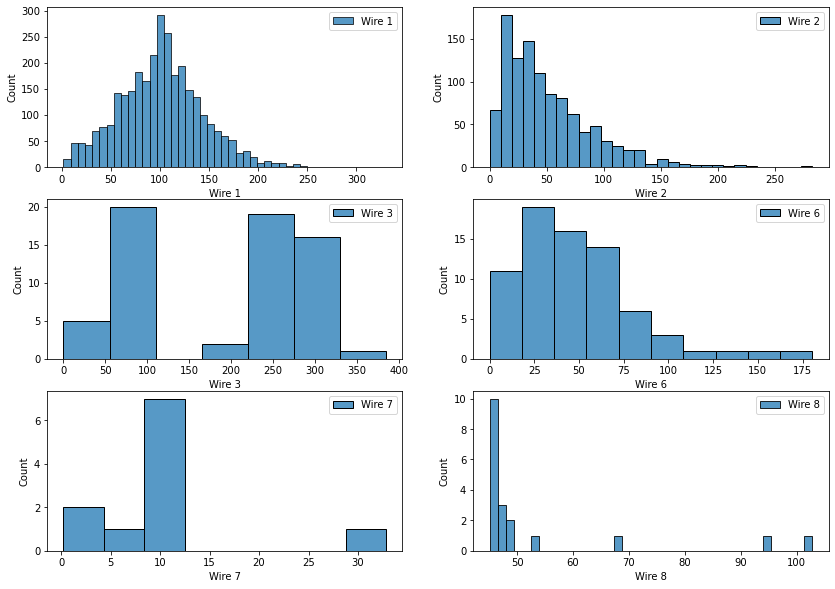

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(14,10))
sns.histplot(df_wire['Wire 1'], ax=axes[0, 0], label='Wire 1')
axes[0, 0].legend()
sns.histplot(df_wire['Wire 2'], ax=axes[0, 1], label='Wire 2')
axes[0, 1].legend()
sns.histplot(df_wire['Wire 3'], ax=axes[1, 0], label='Wire 3')
axes[1, 0].legend()
sns.histplot(df_wire['Wire 6'], ax=axes[1, 1], label='Wire 6')
axes[1, 1].legend()
sns.histplot(df_wire['Wire 7'], ax=axes[2, 0], label='Wire 7')
axes[2, 0].legend()
sns.histplot(df_wire['Wire 8'], ax=axes[2, 1], label='Wire 8')
axes[2, 1].legend()
plt.show()

Для первой, второй и шестой проволоки есть сильный скос вправо, возможно это аномалии. Для остальных проводов все неоднозначно, нужно уточнить у заказчика, в каких диапазонах лежит объем проволоки.

Перейдем к рассмотрению времени загрузки.

In [59]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
for el in [col for col in df_wire_time.columns if col != 'key']:
    df_wire_time[el] = pd.to_datetime(df_wire_time[el])

In [61]:
df_wire_time.describe(datetime_is_numeric=True)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-03 02:48:18.296235776,2019-07-04 03:36:02.886005504,2019-07-07 13:45:31.634920704,2019-07-08 10:06:53.999999744,2019-08-08 16:01:07,2019-07-04 11:29:18.273972480,2019-08-02 18:36:35.818181632,2019-06-21 00:52:37.894736896,2019-06-28 18:07:46.931034624
min,1.000000,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:08:44,2019-05-14 00:03:32,2019-05-04 16:09:11
25%,823.000000,2019-06-03 02:59:53.500000,2019-06-03 21:52:38,2019-06-09 14:51:42.500000,2019-07-17 08:17:59,2019-08-08 16:01:07,2019-05-08 13:11:38,2019-07-23 19:31:31,2019-05-14 02:36:03.500000,2019-06-07 20:28:19
50%,1619.000000,2019-06-30 14:38:56,2019-07-02 06:40:13,2019-07-17 21:35:47,2019-07-23 10:44:22.500000,2019-08-08 16:01:07,2019-07-24 03:28:47,2019-08-08 10:43:30,2019-05-14 05:14:25,2019-06-09 10:26:00
75%,2434.000000,2019-08-03 22:58:26,2019-08-04 13:10:39.500000,2019-08-08 10:03:45,2019-07-23 15:27:14.750000128,2019-08-08 16:01:07,2019-08-08 20:28:45,2019-08-08 12:43:10.500000,2019-08-11 11:43:21.500000,2019-08-04 20:48:59
max,3241.000000,2019-09-01 04:16:01,2019-08-31 18:50:15,2019-08-28 02:11:18,2019-08-08 12:03:12,2019-08-08 16:01:07,2019-08-14 00:59:11,2019-08-08 18:27:34,2019-08-11 15:09:29,2019-08-29 03:51:31
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


С датами все в порядке.

### Продувка сплава газом

In [62]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Пока что непонятно, что означает поле *Газ 1*, но в любом случае стоит посмотреть на его распределение.

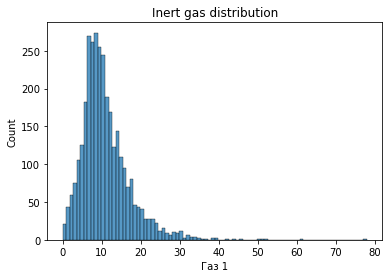

In [63]:
sns.histplot(df_gas['Газ 1'])
plt.title('Inert gas distribution')
plt.show()

Распределение имеет нормальный вид, однако скошено вправо. Возможно это выбросы, стоит уточнить у заказчика.

### Температура

In [64]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Посмотрим на распределение целевого признака.

In [65]:
df_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

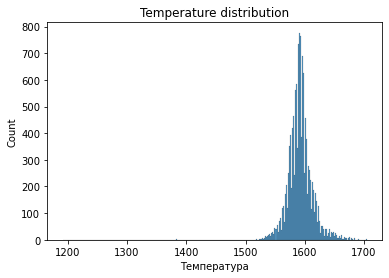

In [66]:
sns.histplot(df_temp['Температура'])
plt.title('Temperature distribution')
plt.show()

Температура распределена нормально и лежит в диапазоне примерно от 1500 до 1700. Однако имеются выбросы. В некоторых точках температура слишком низкая. Посмотрим на эти точки.

In [67]:
df_temp[df_temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Нужно уточнить, являются ли данные температуры приемлемыми для процесса.

## Уточняющие вопросы

1. Таблица по электродам:
    - В чем измеряется активная и реактивная мощности? В каких диапазонах они должны лежать?
    - Активная и реактивная мощности сильно скорреклированы. Можно ли выбросить реактивную мощность и использовать лишь активную?
    - Через время начала и время конца нагрева была вычислена продолжительность нагрева. Данная величина лежит в диапазоне от 11 до 907 секунд (распределена нормально, но скошена вправо). Соответствует ли это действительности?
    - Как оценивать влияние электродов на температуру? Если мощность указана в Ваттах, то логично будет умножить ее на продолжительность нагрева, получив тем самым вложенную энергию. Однако стоит отметить, что продолжительность сильно скоррелирована с мощностью. Соответствует ли это реальному процессу?
2. Таблицы по подаче сыпучих веществ и проволоки:
    - Что означают столбцы "Bulk 1", "Bulk 2", "Wire 1", "Wire 2" и т.д.? Это объемы каких-то веществ? Если да, нужно ли нам знать, каких именно веществ? В чем измеряется объем?
    - Для некоторых партий нет информации о подаче сыпучих материалов и проволоки. Можем ли мы считать, что в этих партиях не осуществлялась подача легирующих веществ?
    - В таблицах огромное количество пропусков. Я правильно понимаю, что пропуск означает то, что данное вещество не подавалось в сплав данной партии?
    - Верно ли предположение, что подача сыпучих материалов производится в момент работы электродов?
    - Верно ли предположение, что подача проволоки производится в момент, когда электроды отключены?
    - В некоторых столбцах имеются необычно большие и необычно маленькие значения. В каких даиапазонах должны лежать объемы сыпучих материалов и проволоки? Если значение не попадает в диапазон, что нам с ним делать? Можно ли счесть его выбросом и удалить?
3. Таблица по продувке сплава газом:
    - Какая величина содержится в поле *Газ 1*? В чем она измеряется? 
    - Как осуществляется продувка: один раз или постоянно на протяжении обработки партии? В какой момент времени осуществляется продувка?
    - Распределение скошено вправо, возможно крайне правые значения - выбросы. В каких диапазонах должна лежать данная величина?
4. Таблица по температуре:
    - Примерно для 18% моментов во времени значение в поле "Температура" пропущено. Правильно ли я понимаю, что эти замеры нам нужно предсказать, и соответствующие строки будут тестовой выборкой?
    - Судя по данным, температура лежит в диапазоне от 1500 до 1700 градусов, однако есть 7 замеров, где температура существенно ниже (1200-1300). Стоит ли считать данные измерения выбросами и удалить их? В каких диапазонах должна лежать температура?
    - Сплав всегда поступает в котел при одинаковой температуре?
    - Верно ли утверждение, что измерение температуры производится в момент, когда электроды отключены?
5. Предсказательная модель:
    - Как я понимаю, мы должны уметь предсказывать температуру сплава в любой момент времени, учитывая, сколько легирующих элементов уже поступило в него, сколько энергии было вложено электродами, а также сколько газа было использовано для продувки. Верно ли утверждение?
    - В продолжение предыдущего вопроса, что стоит считать признаками для модели? Стоит ли для каждой партии для каждого замера (т.е. момента времени) определить объем уже попавших в сплав легирующих веществ и количества вложенной энергии (осуществляется через время, т.к. оно известно)? Как лучше учесть количество вложенной от электродов энергии? Стоит ли учитывать время, в течение которого электроды были выключены?
    - Какую метрику качества использовать? И какую величину метрики нужно достичь?
    - Есть ли какие-либо требования по скорости работы модели?
    - Влияет ли температура одной партии сплава на следующую партию?
    - Стоит ли решать данную задачу как задачу временного ряда? Стоит ли как признак использовать температуру сплава на момент предыдущего замера?

## Примерный план решения задачи

1. Объединить все таблицы в одну по полям партий сплава и времени. В результате должны получить таблицу, где в каждой строке содержится момент времени и количество веществ и энергии, вложенной в сплав к этому моменту времени.
2. Еще раз осмотреть данные, заполнить пропуски и вычистить аномалии. Посмотреть, какие признаки оказывают сильное влияние на температуру, а какие нет, затем удалить неважные признаки (а также сильно коррелирующие).
3. Выделить обучающую и тестовую выборки.
4. Обучить несколько моделей, для каждой оптимизировать гиперпараметры, оценить качество на кросс-валидации. Выбрать наилучшую модель среди обученных. Если это важно заказчику, то оценить скорость обучения моделей.

# Моделирование

## Предобработка данных

На основе проведенного исследовательского анализа данных и информации о производственном процессе, подготовим данные к разработке предсказательной модели.

Соберем все таблицы в одну, чтобы сформировать признаки. 

### Создание единой таблицы признаков

#### Температура

In [68]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [69]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Нас интересует входной и выходной замеры температуры.

In [70]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

Начнем создавать таблицу, в которую будем записывать необходимые нам признаки.

In [71]:
df_features = pd.DataFrame({'key': [],
                            'initial_time': [],
                            'initial_temp': [],
                            'control_time': [],
                            'control_temp': []})

In [72]:
%%time
for key, df in df_temp.groupby('key'):
    df = df.reset_index(drop=True)
    initial_time = df.iloc[0]['Время замера']
    initial_temp = df.iloc[0]['Температура']
    final_time = df.iloc[-1]['Время замера']
    final_temp = df.iloc[-1]['Температура']
    df_features = df_features.append({'key': key,
                                      'initial_time': initial_time,
                                      'initial_temp': initial_temp,
                                      'control_time': final_time,
                                      'control_temp': final_temp}, 
                                      ignore_index=True)

Wall time: 6.81 s


In [73]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


In [74]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3216 non-null   float64       
 1   initial_time  3216 non-null   datetime64[ns]
 2   initial_temp  3216 non-null   float64       
 3   control_time  3216 non-null   datetime64[ns]
 4   control_temp  2477 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 125.8 KB


Строки с пропущенной температурой нам не интересны, можем их удалить.

In [75]:
df_features = df_features.dropna()

Добавим поле *продолжительность процесса*, характеризующее количество секунд от первого до контрольного замеров.

In [76]:
df_features['duration'] = (df_features['control_time'] - df_features['initial_time']).dt.seconds

In [77]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762


Важно, чтобы длительность процесса не была равна 0, что означает, что у нас был всего один замер для конкретной партии. Такие партии стоит удалить.

In [78]:
df_features[df_features['duration'] == 0]

,key,initial_time,initial_temp,control_time,control_temp,duration
192,195.0,2019-05-10 14:10:23,1583.0,2019-05-10 14:10:23,1583.0,0
276,279.0,2019-05-13 23:07:28,1603.0,2019-05-13 23:07:28,1603.0,0


Имеем 2 партии, удаляем их.

In [79]:
df_features = df_features[df_features['duration'] != 0]

#### Электроды

In [80]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,interval,duration,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,"[2019-05-03 11:02:14, 2019-05-03 11:06:02]",228,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,"[2019-05-03 11:07:28, 2019-05-03 11:10:33]",185,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,"[2019-05-03 11:11:44, 2019-05-03 11:14:36]",172,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,"[2019-05-03 11:18:14, 2019-05-03 11:24:19]",365,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,"[2019-05-03 11:26:09, 2019-05-03 11:28:37]",148,102.527702


In [81]:
df_arc_features = pd.DataFrame({'key': [],
                                'energy_by_electrods': [],
                                'heating_repetitions': [],
                                'heating_duration': []})

In [82]:
%%time
for key, df in df_arc.groupby('key'):
    df = df.reset_index(drop=True)
    energy_given_by_electrods = 0
    heating_repetitions = 0
    heating_duration = 0
    for i in range(len(df)):
        if df.loc[i, 'Начало нагрева дугой'] > df_features[df_features['key'] == key]['initial_time'].values \
        and df.loc[i, 'Конец нагрева дугой'] < df_features[df_features['key'] == key]['control_time'].values:
            energy_given_by_electrods += df.loc[i, 'energy']
            heating_repetitions += 1
            heating_duration += df.loc[i, 'duration']
    df_arc_features = df_arc_features.append({'key': key,
                                              'energy_by_electrods': energy_given_by_electrods,
                                              'heating_repetitions': heating_repetitions,
                                              'heating_duration': heating_duration},
                                            ignore_index=True)

<timed exec>:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Wall time: 10.3 s


In [83]:
df_arc_features.head()

,key,energy_by_electrods,heating_repetitions,heating_duration
0,1.0,708.195035,2.0,513.0
1,2.0,673.801792,3.0,674.0
2,3.0,146.208505,4.0,375.0
3,4.0,339.425494,1.0,278.0
4,5.0,691.980241,2.0,486.0


Мержим данный датасет к датасету с температурами.

In [84]:
df_features = df_features.merge(df_arc_features, how='left', on='key')

In [85]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0


In [86]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  2475 non-null   float64       
 1   initial_time         2475 non-null   datetime64[ns]
 2   initial_temp         2475 non-null   float64       
 3   control_time         2475 non-null   datetime64[ns]
 4   control_temp         2475 non-null   float64       
 5   duration             2475 non-null   int64         
 6   energy_by_electrods  2475 non-null   float64       
 7   heating_repetitions  2475 non-null   float64       
 8   heating_duration     2475 non-null   float64       
dtypes: datetime64[ns](2), float64(6), int64(1)
memory usage: 193.4 KB


Пропусков нет, однако для некоторых партий может не быть информации о нагреве (или нагрева и не было между интересующими нас замерами). Посмотрим на эти строки.

In [87]:
len(df_features[df_features['energy_by_electrods'] == 0])

34

In [88]:
df_features[df_features['energy_by_electrods'] == 0].head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration
46,49.0,2019-05-05 03:50:08,1626.0,2019-05-05 04:27:11,1588.0,2223,0.0,0.0,0.0
216,220.0,2019-05-11 09:40:31,1618.0,2019-05-11 10:01:15,1583.0,1244,0.0,0.0,0.0
242,246.0,2019-05-12 10:54:47,1575.0,2019-05-12 11:09:43,1577.0,896,0.0,0.0,0.0
243,247.0,2019-05-12 11:56:26,1616.0,2019-05-12 12:18:22,1591.0,1316,0.0,0.0,0.0
244,248.0,2019-05-12 12:58:56,1640.0,2019-05-12 13:13:28,1622.0,872,0.0,0.0,0.0


Если нагрева не было, то логично предположить, что температура сплава должна падать. Проверим, есть ли партии, в которых температура аномально росла.

In [89]:
df_features[(df_features['initial_temp'] < df_features['control_temp']) & (df_features['energy_by_electrods'] == 0)]

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration
242,246.0,2019-05-12 10:54:47,1575.0,2019-05-12 11:09:43,1577.0,896,0.0,0.0,0.0


В одной партии при отсутствии нагрева температура сплава выросла на 2 градуса. Возможно, это погрешность приборов, однако для нас данная строка может считаться выбросом, удалим ее.

In [90]:
mask = (df_features['initial_temp'] < df_features['control_temp']) & (df_features['energy_by_electrods'] == 0)

In [91]:
df_features = df_features.drop(df_features[mask].index)

#### Продувка газом

У нас не так много информации о том, что подразумевает собой продувка и в чем измеряется, поэтому просто присоединяем данную таблицу по полю *key* и считаем, что это количество газа, использованного во время обработки данной партии.

In [92]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [93]:
df_features = df_features.merge(df_gas, how='left', on='key')

In [94]:
df_features = df_features.rename(columns={'Газ 1': 'gas'})

In [95]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692


#### Легирование

У нас имеется 4 таблицы по легированию. Две из них характеризуют объем, две - время добавки. Действовать будем следующим образом:
1) Добавляем таблицу с объемами и временем присыпок по полю *key*. <br>
2) Добавляем данные про проволоку.<br>
3) Определяем время, когда была добавлена последняя присыпка или проволока. Если это происходило после контрольного замера температуры, значит сплав на момент контрольного замера был не готов, и такая строка нам не нужна.<br>
4) Если же добавление произошло до замера, то ситуация спорная. Примем решение, посмотрев на соответствующие строки.

In [96]:
df_features = df_features.merge(df_bulk, how='left', on='key')

In [97]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [98]:
df_features = df_features.merge(df_bulk_time, how='left', on='key', suffixes=('_vol', '_time'))

In [99]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Bulk 6_time,Bulk 7_time,Bulk 8_time,Bulk 9_time,Bulk 10_time,Bulk 11_time,Bulk 12_time,Bulk 13_time,Bulk 14_time,Bulk 15_time
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [100]:
df_features = df_features.merge(df_wire, how='left', on='key')

In [101]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Bulk 15_time,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
df_features = df_features.merge(df_wire_time, how='left', on='key', suffixes=('_vol', '_time'))

In [103]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,NaN,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,NaN,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,NaN,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,NaN,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Определим время последней засыпки.

In [104]:
def get_last_bulk_wire(row):
    dates = []
    for i in range(1, 16):
        col = f'Bulk {i}_time'
        date = row[col]
        if not pd.isnull(date):
            dates.append(row[col])
    for i in range(1, 10):
        col = f'Wire {i}_time'
        date = row[col]
        if not pd.isnull(date):
            dates.append(row[col])
    if dates == []:
        return np.NaN
    return np.max(dates)

In [105]:
df_features['last_adding_time'] = df_features.apply(get_last_bulk_wire, axis=1)

In [106]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,last_adding_time
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:21:30
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:46:38
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:31:06
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:43
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:32:06


Посмотрим, есть ли у нас строки, где добавление веществ было после контрольного замера.

In [107]:
len(df_features[df_features['last_adding_time'] > df_features['control_time']])

9

В 9 строках еще что-то добавляли после измерения температуры. Нам такие строки не нужны.

In [108]:
df_features = df_features[~(df_features['last_adding_time'] > df_features['control_time'])]

Проделаем тоже самое, но для первой по времени добавки.

In [109]:
def get_first_bulk_wire(row):
    dates = []
    for i in range(1, 16):
        col = f'Bulk {i}_time'
        date = row[col]
        if not pd.isnull(date):
            dates.append(row[col])
    for i in range(1, 10):
        col = f'Wire {i}_time'
        date = row[col]
        if not pd.isnull(date):
            dates.append(row[col])
    if dates == []:
        return np.NaN
    return np.min(dates)

In [110]:
df_features['first_adding_time'] = df_features.apply(get_first_bulk_wire, axis=1)

In [111]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,last_adding_time,first_adding_time
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:21:30,2019-05-03 11:03:52
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:46:38,2019-05-03 11:40:20
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:31:06,2019-05-03 12:09:40
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:43,2019-05-03 12:41:24
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:32:06,2019-05-03 13:12:56


Посмотрим, в скольких партиях добавки были совершены еще до замеров температуры.

In [112]:
len(df_features[df_features['first_adding_time'] < df_features['initial_time']])

418

In [113]:
df_features[df_features['first_adding_time'] < df_features['initial_time']].head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,last_adding_time,first_adding_time
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:21:30,2019-05-03 11:03:52
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:31:06,2019-05-03 12:09:40
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:43,2019-05-03 12:41:24
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:32:06,2019-05-03 13:12:56
7,8.0,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0,934,468.134803,2.0,390.0,15.171553,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:04:05,2019-05-03 14:55:46


Не хочется удалять 418 строк, так как это примерно 1/6 наших данных, однако это стоит учесть.

Сам по себе момент добавки в сплав легирующих элементов ничего нам не дает, однако можно высчитать, через сколько секунд после начала эта добавка была сделана. Если же добавка была выполнена до первого замера (или ее не было совсем), то проставим 0, подразумевая, что эта добавка уже повлияла на температуру сплава. 

Изменим все столбцы, характеризующие время легирования. Однако перед этим посмотрим на количество пропусков.

In [114]:
df_features.notna().sum().to_frame()

,0
key,2465
initial_time,2465
initial_temp,2465
control_time,2465
control_temp,2465
duration,2465
energy_by_electrods,2465
heating_repetitions,2465
heating_duration,2465
gas,2463


8 присыпку добавляли лишь раз, 5 проволоку ни разу, а 7 проволоку всего 4 раза. Данные столбцы абсолютно бесполезны, надо будет удалить их позже.

In [115]:
def get_time_delta_adding(row):    
    if row[col] > row['initial_time']:
        return (row[col] - row['initial_time']).seconds
    return 0    

In [116]:
for i in range(1, 16):
        col = f'Bulk {i}_time'
        df_features[col] = df_features.apply(get_time_delta_adding, axis=1)

In [117]:
for i in range(1, 10):
        col = f'Wire {i}_time'
        df_features[col] = df_features.apply(get_time_delta_adding, axis=1)

In [118]:
df_features.head()

,key,initial_time,initial_temp,control_time,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,...,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time,last_adding_time,first_adding_time
0,1.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861,708.195035,2.0,513.0,29.749986,...,0,0,0,0,0,0,0,0,2019-05-03 11:21:30,2019-05-03 11:03:52
1,2.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305,673.801792,3.0,674.0,12.555561,...,0,0,0,0,0,0,0,0,2019-05-03 11:46:38,2019-05-03 11:40:20
2,3.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300,146.208505,4.0,375.0,28.554793,...,0,0,0,0,0,0,0,0,2019-05-03 12:31:06,2019-05-03 12:09:40
3,4.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388,339.425494,1.0,278.0,18.841219,...,0,0,0,0,0,0,0,0,2019-05-03 12:48:43,2019-05-03 12:41:24
4,5.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762,691.980241,2.0,486.0,5.413692,...,527,0,0,0,0,0,0,0,2019-05-03 13:32:06,2019-05-03 13:12:56


#### Удаление неинформативных столбцов

Удалим отмеченные выше столбцы - *Bulk 8_vol*, *Bulk 8_time*, *Wire 5_vol*, *Wire 5_time*, *Wire 7_vol*, *Wire 7_time*, так как в них почти нет значений.<br>
Также удаляем столбцы со временем.<br>
Поле *key* нам также не нужно.

In [119]:
df_features = df_features.drop(['Bulk 8_vol', 
                                'Bulk 8_time', 
                                'Wire 5_vol', 
                                'Wire 5_time', 
                                'Wire 7_vol', 
                                'Wire 7_time',
                                'initial_time',
                                'control_time',
                                'last_adding_time',
                                'first_adding_time',
                                'key'], 
                               axis=1)

In [120]:
df_features.head()

,initial_temp,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
0,1571.0,1613.0,861,708.195035,2.0,513.0,29.749986,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,1581.0,1602.0,1305,673.801792,3.0,674.0,12.555561,NaN,NaN,NaN,...,NaN,NaN,NaN,523,0,0,0,0,0,0
2,1596.0,1599.0,1300,146.208505,4.0,375.0,28.554793,NaN,NaN,NaN,...,NaN,NaN,NaN,30,0,0,0,0,0,0
3,1601.0,1625.0,388,339.425494,1.0,278.0,18.841219,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,1576.0,1602.0,762,691.980241,2.0,486.0,5.413692,NaN,NaN,NaN,...,NaN,NaN,NaN,0,527,0,0,0,0,0


### Поиск и удаление аномалий

Попытаемся найти значения, которые сильно выбиваются из общего ряда. Так как столбцов очень много, то будем использовать изоляционный лес. 

In [121]:
isolation_forest = IsolationForest(n_estimators=100)
estimator = isolation_forest.fit_predict(df_features.fillna(0))

Посмотрим на значения, который алгоритм счел аномалиями.

In [122]:
df_features[estimator == -1]

,initial_temp,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
41,1600.0,1603.0,10773,2289.219294,11.0,1917.0,21.265271,NaN,NaN,NaN,...,NaN,NaN,NaN,1106,0,0,0,0,0,0
43,1607.0,1612.0,12010,3119.397579,11.0,2619.0,6.118441,NaN,NaN,NaN,...,NaN,NaN,NaN,3358,0,0,0,0,0,0
110,1645.0,1647.0,2969,914.110836,3.0,693.0,25.377930,NaN,228.0,NaN,...,60.094322,NaN,NaN,924,0,1885,1759,1096,0,0
111,1631.0,1600.0,2905,328.229469,2.0,379.0,14.683228,NaN,247.0,NaN,...,54.122643,NaN,NaN,0,0,1647,1508,1008,0,0
112,1635.0,1547.0,5878,174.736203,5.0,544.0,22.201580,78.0,232.0,NaN,...,64.212723,NaN,NaN,0,0,0,0,2240,0,0
114,1625.0,1604.0,3184,392.304174,5.0,679.0,50.581035,52.0,325.0,NaN,...,26.975523,NaN,NaN,0,0,1448,0,1310,0,0
115,1652.0,1600.0,9598,1828.840801,5.0,1122.0,38.982740,69.0,257.0,NaN,...,60.025684,NaN,NaN,0,0,1217,0,916,0,0
116,1628.0,1593.0,1425,72.467964,1.0,132.0,17.875612,51.0,233.0,NaN,...,43.174561,NaN,NaN,0,0,1173,0,928,0,0
274,1532.0,1600.0,2867,1800.188677,8.0,1648.0,60.935689,NaN,NaN,126.0,...,NaN,46.002319,NaN,1219,1902,0,0,0,2590,0
285,1591.0,1617.0,3807,2557.323663,5.0,1303.0,17.724259,NaN,NaN,NaN,...,NaN,NaN,NaN,2648,3464,0,0,0,0,0


Сложно сказать, что не так с даннными строками, однако доверимся алгоритму и удалим их.

In [123]:
df_feautres = df_features.drop(df_features[estimator == -1].index)

Алгоритм мог многое упустить, а так же он не знает технологический процесс. Вызовем метод .describe() и посмотрим на минимальные, максимальные и квартильные значения столбцов. Если заметим что-то странное, то рассмотрим детальнее.

In [124]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
initial_temp,2465.0,1588.407708,29.246123,1191.000000,1572.000000,1588.000000,1605.000000,1679.000000
control_temp,2465.0,1595.348073,16.030908,1541.000000,1587.000000,1593.000000,1599.000000,1700.000000
duration,2465.0,1856.414199,1301.797349,234.000000,1186.000000,1594.000000,2263.000000,23537.000000
energy_by_electrods,2465.0,605.872678,507.530474,0.000000,275.353088,494.511640,797.565988,8591.676556
heating_repetitions,2465.0,3.497769,1.590638,0.000000,2.000000,3.000000,4.000000,15.000000
heating_duration,2465.0,628.799189,335.617178,0.000000,400.000000,599.000000,808.000000,4092.000000
gas,2463.0,11.155865,6.324875,0.008399,7.115208,9.942109,13.873797,77.995040
Bulk 1_vol,199.0,40.115578,18.226180,10.000000,27.000000,33.000000,46.500000,185.000000
Bulk 2_vol,13.0,254.846154,25.973853,228.000000,242.000000,248.000000,258.000000,325.000000
Bulk 3_vol,960.0,115.017708,77.420959,6.000000,57.750000,97.000000,152.250000,454.000000


#### Температура и нагрев

Во время исследовательского анализа данных было установлено, что температура лежит в диапазоне от 1500 до 1700 градусов. Посмотрим на строки, чья температура ниже 1500.

In [125]:
df_features[df_features['initial_temp'] < 1500]

,initial_temp,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
852,1191.0,1599.0,2177,607.452851,6.0,834.0,11.616807,NaN,NaN,264.0,...,NaN,NaN,NaN,716,1378,0,0,0,0,0
1198,1208.0,1591.0,2565,414.907717,2.0,391.0,12.933558,NaN,NaN,NaN,...,NaN,NaN,NaN,1092,0,0,0,0,0,0
1601,1218.0,1590.0,1080,40.327171,1.0,109.0,4.542025,NaN,NaN,45.0,...,NaN,NaN,NaN,315,1028,0,0,0,0,0
2033,1227.0,1592.0,1946,376.147240,4.0,541.0,8.639928,NaN,NaN,NaN,...,NaN,NaN,NaN,1176,0,0,0,0,0,0


Температура плавления стали около 1450 градусов. Делаем вывод, что это аномалии, удаляем их.

In [126]:
df_features = df_features[df_features['initial_temp'] > 1500]

Рассмотрим продолжительность процесса, так как максимальная продолжительность превышает 20 тысяч секунд или несколько часов, что странно. Спорными значениями будем считать величины, превышающую величину третьего квартиля плюс 3 межквартильных расстояния.

In [127]:
def get_upper_border(col):
    return df_features[col].quantile(0.75) + (df_features[col].quantile(0.75) - df_features[col].quantile(0.25)) * 3

In [128]:
get_upper_border('duration')

5494.0

In [129]:
df_features[df_features['duration'] > 5494]

,initial_temp,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
41,1600.0,1603.0,10773,2289.219294,11.0,1917.0,21.265271,NaN,NaN,NaN,...,NaN,NaN,NaN,1106,0,0,0,0,0,0
43,1607.0,1612.0,12010,3119.397579,11.0,2619.0,6.118441,NaN,NaN,NaN,...,NaN,NaN,NaN,3358,0,0,0,0,0,0
112,1635.0,1547.0,5878,174.736203,5.0,544.0,22.201580,78.0,232.0,NaN,...,64.212723,NaN,NaN,0,0,0,0,2240,0,0
115,1652.0,1600.0,9598,1828.840801,5.0,1122.0,38.982740,69.0,257.0,NaN,...,60.025684,NaN,NaN,0,0,1217,0,916,0,0
269,1568.0,1592.0,6518,2304.106803,9.0,1774.0,5.583702,NaN,NaN,226.0,...,NaN,NaN,NaN,735,779,0,0,0,0,0
316,1619.0,1616.0,6725,2366.151558,12.0,2509.0,77.995040,185.0,NaN,101.0,...,NaN,NaN,NaN,0,1661,0,0,0,0,0
453,1573.0,1586.0,5612,716.554173,4.0,874.0,11.014079,NaN,NaN,NaN,...,NaN,NaN,NaN,4410,0,0,0,0,0,0
626,1588.0,1619.0,12789,2660.983312,9.0,1814.0,19.798236,NaN,NaN,99.0,...,NaN,NaN,NaN,17,0,0,0,0,0,0
627,1610.0,1615.0,7506,1983.397672,5.0,1260.0,23.658727,NaN,NaN,NaN,...,NaN,NaN,NaN,38,0,0,0,0,0,0
629,1617.0,1580.0,16669,1862.505982,4.0,1180.0,20.984894,NaN,NaN,NaN,...,NaN,NaN,NaN,132,0,0,0,0,0,0


Видно, что в этих строках преимущественно вложено куда больше энергии, что логично, так как процесс шел долго. В тех же партиях, где было вложено мало энергии, температура падала, что также логично. Делаем вывод, что данные значения не являются аномалиями.

#### Добавление веществ

Рассмотрим столбцы, характеризующие объем добавленных веществ (сыпучих или проволочных).

Найдем колонки, где есть значения, превышающие величину ***Q3 + 3IQR***.

In [130]:
cols_with_potential_anomalies = []
for i in range(1, 16):
    col = f'Bulk {i}_vol'
    if col in df_features.columns:
        tmp_df = df_features[df_features[col] > get_upper_border(col)]
        if len(tmp_df) > 0:
            cols_with_potential_anomalies.append(col)
    col = f'Wire {i}_vol'
    if col in df_features.columns:
        tmp_df = df_features[df_features[col] > get_upper_border(col)]
        if len(tmp_df) > 0:
            cols_with_potential_anomalies.append(col)

In [131]:
cols_with_potential_anomalies

['Bulk 1_vol',
 'Wire 1_vol',
 'Bulk 2_vol',
 'Wire 2_vol',
 'Bulk 3_vol',
 'Bulk 5_vol',
 'Bulk 6_vol',
 'Wire 8_vol',
 'Bulk 9_vol',
 'Bulk 12_vol',
 'Bulk 13_vol',
 'Bulk 14_vol']

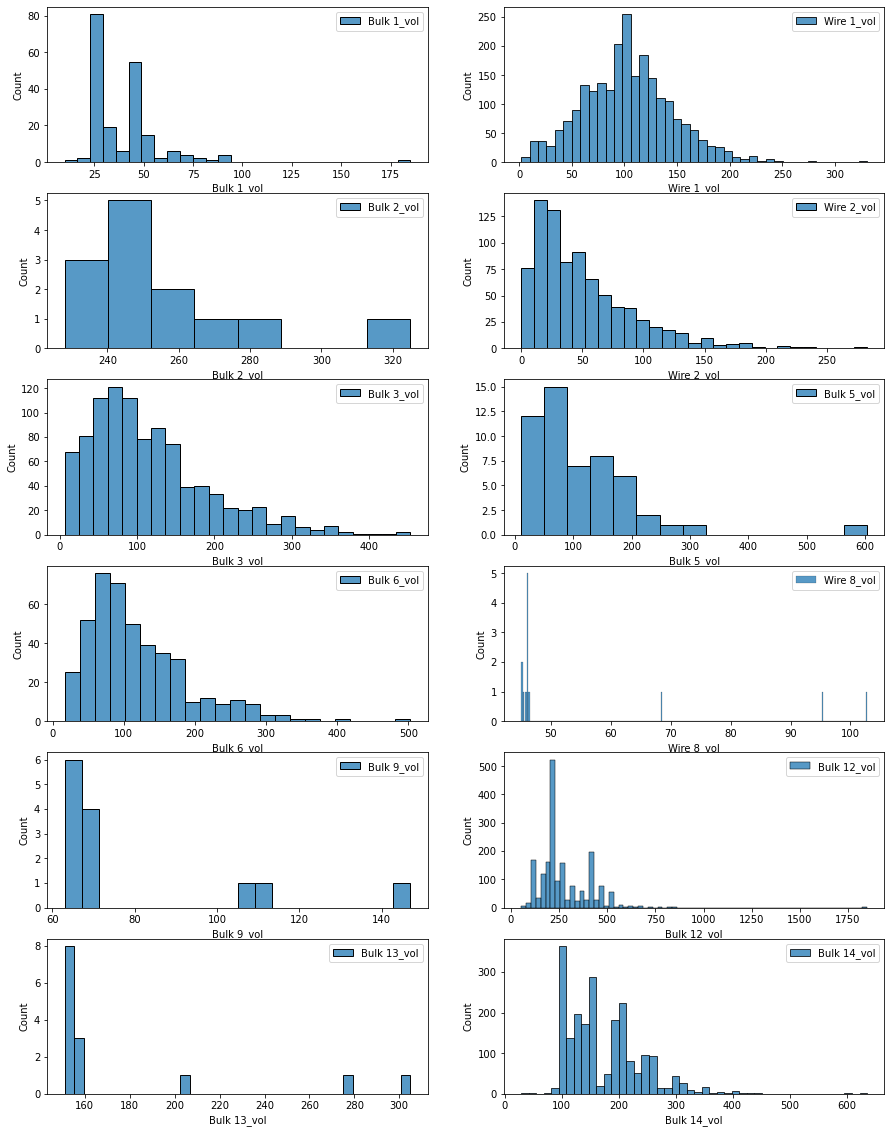

In [132]:
fig, axes = plt.subplots(6, 2, figsize=(15, 20))
for i in range(len(cols_with_potential_anomalies)):
    x = i // 2
    y = i % 2
    col = cols_with_potential_anomalies[i]
    sns.histplot(df_features[col], ax=axes[x, y], label=col)
    axes[x, y].legend()    
plt.show()

- Столбцы *Bulk 2_vol*, *Bulk 5_vol*, *Wire 8_vol*, *Bulk 9_vol*, *Bulk 13_vol* имеют отнсительно немного значений, поэтому назвать большое значение в них выбросом сложно. Принимаем решение не трогать данные столбцы.
- В остальных столбцах четко видны значения, которые сильно превышают все остальные, от них лучше избавиться.

До удаления:

In [133]:
init_len = len(df_features)

In [134]:
init_len

2461

In [135]:
limits = pd.DataFrame()
limits['columns'] = ['Bulk 1_vol', 'Wire 1_vol', 'Wire 2_vol', 'Bulk 3_vol', 'Bulk 6_vol', 'Bulk 12_vol', 'Bulk 14_vol']
limits['upper_limit'] = limits['columns'].apply(get_upper_border)

In [136]:
limits

,columns,upper_limit
0,Bulk 1_vol,105.000000
1,Wire 1_vol,290.613964
2,Wire 2_vol,219.628250
3,Bulk 3_vol,433.250000
4,Bulk 6_vol,404.000000
5,Bulk 12_vol,828.000000
6,Bulk 14_vol,466.000000


In [137]:
for row in limits.itertuples():
    col = row.columns
    border = row.upper_limit
    df_features = df_features[df_features[col].fillna(0) <= border]

In [138]:
init_len - len(df_features)

11

Всего 11 строк было удалено.

Посмотрим на датасет после обработки аномалий.

In [139]:
df_features.head()

,initial_temp,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
0,1571.0,1613.0,861,708.195035,2.0,513.0,29.749986,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,1581.0,1602.0,1305,673.801792,3.0,674.0,12.555561,NaN,NaN,NaN,...,NaN,NaN,NaN,523,0,0,0,0,0,0
2,1596.0,1599.0,1300,146.208505,4.0,375.0,28.554793,NaN,NaN,NaN,...,NaN,NaN,NaN,30,0,0,0,0,0,0
3,1601.0,1625.0,388,339.425494,1.0,278.0,18.841219,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,1576.0,1602.0,762,691.980241,2.0,486.0,5.413692,NaN,NaN,NaN,...,NaN,NaN,NaN,0,527,0,0,0,0,0


In [140]:
len(df_features)

2450

### Заполнение пропусков

Посмотрим на количество пропусков.

In [141]:
df_features.isna().sum()

initial_temp              0
control_temp              0
duration                  0
energy_by_electrods       0
heating_repetitions       0
heating_duration          0
gas                       2
Bulk 1_vol             2254
Bulk 2_vol             2437
Bulk 3_vol             1499
Bulk 4_vol             1643
Bulk 5_vol             2398
Bulk 6_vol             2012
Bulk 7_vol             2437
Bulk 9_vol             2437
Bulk 10_vol            2308
Bulk 11_vol            2322
Bulk 12_vol             583
Bulk 13_vol            2436
Bulk 14_vol             332
Bulk 15_vol             751
Bulk 1_time               0
Bulk 2_time               0
Bulk 3_time               0
Bulk 4_time               0
Bulk 5_time               0
Bulk 6_time               0
Bulk 7_time               0
Bulk 9_time               0
Bulk 10_time              0
Bulk 11_time              0
Bulk 12_time              0
Bulk 13_time              0
Bulk 14_time              0
Bulk 15_time              0
Wire 1_vol          

Пропуски в столбцах типа *Bulk* и *Wire* говорят о том, что данный материал попросту не добавлялся в сплав. Помимо этого имеем 2 пропуска в поле *gas*, посмотрим на них.

In [142]:
df_features[df_features['gas'].isna()]

,initial_temp,control_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
190,1593.0,1595.0,2487,721.980380,5.0,884.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1237,0,0,0,0,0,0
254,1577.0,1590.0,1080,641.779989,3.0,613.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,463,0,0,0,0,0,0


Строки выглядят нормальными, поэтому продувка должна была быть. Заполним пропуски медианным значением.

In [143]:
df_features['gas'] = df_features['gas'].fillna(df_features['gas'].median())

Оставшиеся пропуски в полях добавляемых веществ смело заполняем нулями.

In [144]:
df_features = df_features.fillna(0)

In [145]:
df_features.isna().sum().sum()

0

### Разделение на тестовую и обучающую выборки

Перед тем, как проводить анализ признаков, лучше разделить данные на обучающую и тестовую выборки для "чистоты эксперимента". Разделим в соотношении 80:20.  

In [146]:
df_train, df_test = train_test_split(df_features, test_size=0.2, random_state=42)

In [147]:
df_train.shape

(1960, 49)

In [148]:
df_test.shape

(490, 49)

Важно, чтобы распределение целевого признака было похожим в обоих выборках.

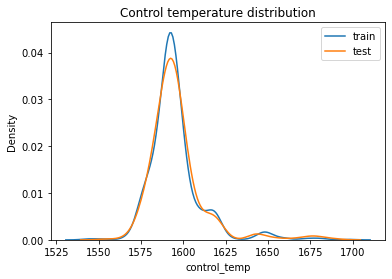

In [149]:
sns.kdeplot(df_train['control_temp'], label='train')
sns.kdeplot(df_test['control_temp'], label='test')
plt.title('Control temperature distribution')
plt.legend()
plt.show()

Распределения похожи, значит разбиение произведено успешно.

### Стандартизация

Сначала выделим признаки и целевой признак.

In [150]:
features_train = df_train.drop('control_temp', axis=1)
y_train = df_train['control_temp']

features_test = df_test.drop('control_temp', axis=1)
y_test = df_test['control_temp']

In [151]:
scaler = StandardScaler()
features_train = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_train.columns) 

In [152]:
features_train.head()

,initial_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,Bulk 4_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
0,0.403588,0.581745,-0.392538,0.958335,0.169884,0.319574,-0.278351,-0.074713,-0.605346,2.475294,...,-0.108412,-0.070716,-0.103227,-0.321115,0.303624,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
1,0.323117,-0.166722,-0.747492,-0.315977,-0.780532,-0.257770,-0.278351,-0.074713,1.634309,1.561477,...,-0.108412,-0.070716,-0.103227,-0.551397,-0.462503,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
2,1.047359,-0.504644,1.407004,-0.315977,0.981067,-0.256010,-0.278351,-0.074713,1.468408,-0.610994,...,-0.108412,-0.070716,-0.103227,-0.733759,-0.462503,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
3,0.363353,2.588527,2.047157,0.958335,1.801330,0.030369,-0.278351,-0.074713,0.569782,-0.610994,...,-0.108412,-0.070716,-0.103227,0.520146,-0.462503,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
4,-0.843717,0.632878,0.532549,2.232647,1.659070,1.669115,-0.278351,-0.074713,-0.605346,-0.610994,...,1.016592,-0.070716,-0.103227,0.488199,-0.462503,-0.119753,-0.063258,5.191218,-0.063373,-0.107399


In [153]:
features_test.head()

,initial_temp,duration,energy_by_electrods,heating_repetitions,heating_duration,gas,Bulk 1_vol,Bulk 2_vol,Bulk 3_vol,Bulk 4_vol,...,Wire 6_vol,Wire 8_vol,Wire 9_vol,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 6_time,Wire 8_time,Wire 9_time
0,-0.401125,-0.350504,-0.086391,0.958335,0.266742,-0.466084,-0.278351,-0.074713,0.085906,-0.610994,...,-0.108412,-0.070716,-0.103227,-0.689832,-0.273525,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
1,-1.728902,0.223074,3.545970,-0.315977,1.353363,-1.191003,2.413879,-0.074713,1.426933,-0.610994,...,-0.108412,-0.070716,-0.103227,0.701177,-0.462503,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
2,-1.447252,-0.582455,0.591962,-0.315977,0.312144,-0.977086,-0.278351,-0.074713,-0.245895,-0.610994,...,-0.108412,-0.070716,-0.103227,-0.032264,0.606670,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
3,-0.562068,-0.220819,0.716408,-0.315977,0.218313,-0.333548,-0.278351,-0.074713,-0.605346,-0.610994,...,-0.108412,-0.070716,-0.103227,0.068900,-0.462503,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399
4,0.484060,-0.066680,-0.464243,0.321179,-0.090421,0.107374,-0.278351,-0.074713,-0.605346,0.354548,...,-0.108412,-0.070716,-0.103227,0.116820,-0.462503,-0.119753,-0.063258,-0.105009,-0.063373,-0.107399


### Вывод

- Все имеющиеся таблицы были объединены в одну по полю *key*, характеризующему номер партии.
- Для каждой партии был выделен первый и последний замер тмепературы. Если был всего 1 замер, то такие строки удалялись.
- Для добавляемых веществ были признаками стали объем добавления и пройденное с момента первого замера время в секундах. Если же добавка веществ осуществлялась после контрольного замера, то такие строки удалялись (так как это значит, что сплав еще не готов).
- Были удалены аномалии.
- Пропуски в поле продувки газом были заполнены медианой, в столбцах легирования - нулями.
- Были выделены обучающая и тестовая выборки.

## Feature engineering

На данный момент у нас очень много признаков. Нужно оставить лишь значимые признаки. 

Проведем корреляционный анализ, а также анализ важности признаков с использованием моделей машинного обучения.

### Корреляционный анализ

In [154]:
corr = features_train.corr().abs()
corr_couples = corr.unstack().sort_values(kind="quicksort", ascending=False).to_frame()
strong_corr = corr_couples[(corr_couples[0] < 1) & (corr_couples[0] > 0.85)].drop_duplicates(subset=0).reset_index()

In [155]:
strong_corr

,level_0,level_1,0
0,Bulk 9_time,Wire 8_time,0.991725
1,Wire 8_vol,Bulk 9_vol,0.972466
2,Bulk 2_vol,Bulk 2_time,0.950103
3,Wire 8_vol,Bulk 9_time,0.918881
4,Wire 8_vol,Wire 8_time,0.897593
5,heating_duration,energy_by_electrods,0.894488
6,Bulk 9_time,Bulk 9_vol,0.885701
7,Wire 4_vol,Wire 4_time,0.875960
8,Bulk 7_time,Bulk 2_time,0.872819
9,Bulk 7_time,Bulk 7_vol,0.870164


Имеем 12 пар. В тех случаях, когда коррелированы признак объема добавляемого вещества и признак времени, всегда оставляем объем вещества, так как нам куда важнее, что добавили в сплав, а не когда это сделали.

Найдем эти признаки.

In [156]:
time_cols_to_drop = []
for row in strong_corr.itertuples():
    col_1 = row.level_0
    col_2 = row.level_1
    if col_1.endswith('_time') and not col_2.endswith('_time') and col_1 not in time_cols_to_drop:
        time_cols_to_drop.append(col_1)
    if col_2.endswith('_time') and not col_1.endswith('_time') and col_2 not in time_cols_to_drop:
        time_cols_to_drop.append(col_2)   

In [157]:
time_cols_to_drop

['Bulk 2_time',
 'Bulk 9_time',
 'Wire 8_time',
 'Wire 4_time',
 'Bulk 7_time',
 'Wire 9_time']

Удалим их.

In [158]:
features_train = features_train.drop(time_cols_to_drop, axis=1)
features_test = features_test.drop(time_cols_to_drop, axis=1)

In [159]:
features_train.shape

(1960, 42)

In [160]:
features_test.shape

(490, 42)

Остались лишь пары: *Wire 8_vol* - *Bulk 9_vol* и *heating_duration* - *energy_by_electrods*. В каждой паре оставим тот признак, который сильнее коррелирован с целевым признаком.

In [161]:
print(f'Wire 8_vol corr: {np.corrcoef(features_train["Wire 8_vol"], y_train)[0, 1]}')
print(f'Bulk 9_vol corr: {np.corrcoef(features_train["Bulk 9_vol"], y_train)[0, 1]}')
print(f'heating_duration corr: {np.corrcoef(features_train["heating_duration"], y_train)[0, 1]}')
print(f'energy_by_electrods corr: {np.corrcoef(features_train["energy_by_electrods"], y_train)[0, 1]}')

Wire 8_vol corr: -0.014028411734026773
Bulk 9_vol corr: -0.018379212837953605
heating_duration corr: 0.21680406365424632
energy_by_electrods corr: 0.29445134094242503


Признаки *Wire 8_vol* и *heating_duration* выбрасываем.

In [162]:
features_train = features_train.drop(['Wire 8_vol', 'heating_duration'], axis=1)
features_test = features_test.drop(['Wire 8_vol', 'heating_duration'], axis=1)

In [163]:
features_train.shape

(1960, 40)

In [164]:
features_test.shape

(490, 40)

### Важность признаков

Определим важность признаков с помощью трех моделей: гребневой регрессии (важность признаков получим через абсолютное значение коэффициентов), случайного леса и градиентного бустинга (в обоих моделях есть специальный метод).

Затем для определения самых важных признаков применим следующий алгоритм:
1. Для каждой модели определим n самых важных признаков и запишем их в множества.
2. Объединим множества.
3. Лишь на этих фичах посмотрим качество модели на кросс-валидации.
4. Повторим для разного n.
5. Выберем n с минимальным значением метрики.

#### Гребневая регрессия

In [165]:
ridge_feature = Ridge()
ridge_feature.fit(features_train, y_train)

Ridge()

In [166]:
ridge_importance = pd.DataFrame({'feature': features_train.columns,
                                 'importance': abs(ridge_feature.coef_)})

In [167]:
ridge_importance.head()

,feature,importance
0,initial_temp,12.706035
1,duration,7.314962
2,energy_by_electrods,12.289043
3,heating_repetitions,3.719703
4,gas,0.104625


#### Случайный лес

In [168]:
rf_feature = RandomForestRegressor(random_state=42)
rf_feature.fit(features_train, y_train)

RandomForestRegressor(random_state=42)

In [169]:
rf_importance = pd.DataFrame({'feature': features_train.columns,
                              'importance': rf_feature.feature_importances_})

In [170]:
rf_importance.head()

,feature,importance
0,initial_temp,0.283472
1,duration,0.031282
2,energy_by_electrods,0.128327
3,heating_repetitions,0.013234
4,gas,0.022890


#### Градиентный бустинг

In [171]:
lgbm_feature = LGBMRegressor(random_state=42)
lgbm_feature.fit(features_train, y_train)

LGBMRegressor(random_state=42)

In [172]:
lgbm_importance = pd.DataFrame({'feature': features_train.columns,
                                'importance': lgbm_feature.feature_importances_})

In [173]:
lgbm_importance.head()

,feature,importance
0,initial_temp,429
1,duration,320
2,energy_by_electrods,403
3,heating_repetitions,121
4,gas,180


#### Объединение важных признаков

In [174]:
def get_features(number_top_features):
    ridge_top = ridge_importance.sort_values(by='importance', ascending=False)[:number_top_features].reset_index(drop=True)['feature']
    rf_top = rf_importance.sort_values(by='importance', ascending=False)[:number_top_features].reset_index(drop=True)['feature']
    lgbm_top = ridge_importance.sort_values(by='importance', ascending=False)[:number_top_features].reset_index(drop=True)['feature']
    best_features = set(ridge_top) | set(rf_top) | set(lgbm_top)
    return features_train[best_features].copy()

In [175]:
mae_over_top_features = []
for i in tqdm(range(1, 30)):
    features = get_features(i)
    model = LGBMRegressor(random_state=42)
    mean_mae = abs(cross_val_score(
        model,
        features,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1)
                   .mean())
    mae_over_top_features.append([i, mean_mae])
mae_over_top_features = pd.DataFrame(mae_over_top_features, columns=['top_features_chosen', 'mae_cv'])

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


Нарисуем график зависимости.

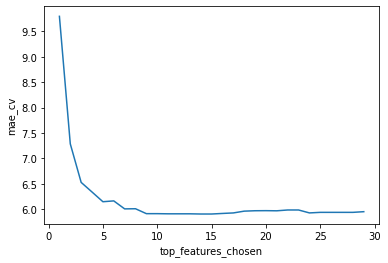

In [176]:
sns.lineplot(data=mae_over_top_features, x='top_features_chosen', y='mae_cv')
plt.show()

Посмотрим, сколько важных признаков надо брать из каждой модели.

In [177]:
mae_over_top_features[mae_over_top_features['mae_cv'] == mae_over_top_features['mae_cv'].min()]

,top_features_chosen,mae_cv
13,14,5.907985
14,15,5.907985


Возьмем 14 наилучших признаков по версии каждого способа.

In [178]:
X_train = get_features(14)

In [179]:
X_train.head()

,Wire 6_vol,Bulk 7_vol,Wire 1_vol,heating_repetitions,Bulk 12_vol,Bulk 6_vol,Bulk 1_vol,Bulk 15_vol,Bulk 14_time,Wire 2_vol,Wire 1_time,Bulk 15_time,Wire 3_time,duration,gas,Bulk 14_vol,Bulk 13_time,energy_by_electrods,initial_temp
0,-0.108412,-0.061491,-0.133139,0.958335,0.022120,-0.406967,-0.278351,1.050055,-0.532844,-0.229339,-0.321115,-0.260876,-0.119753,0.581745,0.319574,-0.604435,-0.041311,-0.392538,0.403588
1,-0.108412,-0.061491,0.620074,-0.315977,0.087523,-0.406967,-0.278351,-0.154560,-0.833412,-0.514533,-0.551397,-0.427102,-0.119753,-0.166722,-0.257770,-0.544221,-0.041311,-0.747492,0.323117
2,-0.108412,-0.061491,-2.091495,-0.315977,-0.311433,-0.406967,-0.278351,-1.312844,0.239386,-0.514533,-0.733759,-0.427102,-0.119753,-0.504644,-0.256010,0.708223,-0.041311,1.407004,1.047359
3,-0.108412,-0.061491,0.640027,0.958335,0.028660,-0.406967,-0.278351,1.061638,0.706423,-0.514533,0.520146,0.424484,-0.119753,2.588527,0.030369,2.382163,-0.041311,2.047157,0.363353
4,1.016592,-0.061491,-1.067257,2.232647,-0.651526,0.064963,-0.278351,1.026889,0.396606,-0.514533,0.488199,0.253144,-0.119753,0.632878,1.669115,1.960668,-0.041311,0.532549,-0.843717


In [180]:
X_test = features_test[X_train.columns]

In [181]:
X_test.head()

,Wire 6_vol,Bulk 7_vol,Wire 1_vol,heating_repetitions,Bulk 12_vol,Bulk 6_vol,Bulk 1_vol,Bulk 15_vol,Bulk 14_time,Wire 2_vol,Wire 1_time,Bulk 15_time,Wire 3_time,duration,gas,Bulk 14_vol,Bulk 13_time,energy_by_electrods,initial_temp
0,-0.108412,-0.061491,-0.576089,0.958335,-1.325172,-0.406967,-0.278351,-1.312844,-0.833412,-0.164393,-0.689832,-0.427102,-0.119753,-0.350504,-0.466084,-1.796665,-0.041311,-0.086391,-0.401125
1,-0.108412,-0.061491,0.043442,-0.315977,3.043716,-0.406967,2.413879,1.061638,-0.181410,-0.514533,0.701177,-0.066520,-0.119753,0.223074,-1.191003,0.587796,-0.041311,3.545970,-1.728902
2,-0.108412,-0.061491,-1.174337,-0.315977,-0.324513,-0.406967,-0.278351,-0.108229,0.304124,1.360408,-0.032264,0.201998,-0.119753,-0.582455,-0.977086,-0.496050,-0.041311,0.591962,-1.447252
3,-0.108412,-0.061491,-0.809535,-0.315977,-0.311433,1.084331,-0.278351,-0.108229,-0.468106,-0.514533,0.068900,0.214784,-0.119753,-0.220819,-0.333548,1.671642,-0.041311,0.716408,-0.562068
4,-0.108412,-0.061491,0.124250,0.321179,0.009040,-0.406967,-0.278351,1.026889,0.535330,-0.514533,0.116820,0.329864,-0.119753,-0.066680,0.107374,0.033830,-0.041311,-0.464243,0.484060


In [182]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Wire 6_vol           1960 non-null   float64
 1   Bulk 7_vol           1960 non-null   float64
 2   Wire 1_vol           1960 non-null   float64
 3   heating_repetitions  1960 non-null   float64
 4   Bulk 12_vol          1960 non-null   float64
 5   Bulk 6_vol           1960 non-null   float64
 6   Bulk 1_vol           1960 non-null   float64
 7   Bulk 15_vol          1960 non-null   float64
 8   Bulk 14_time         1960 non-null   float64
 9   Wire 2_vol           1960 non-null   float64
 10  Wire 1_time          1960 non-null   float64
 11  Bulk 15_time         1960 non-null   float64
 12  Wire 3_time          1960 non-null   float64
 13  duration             1960 non-null   float64
 14  gas                  1960 non-null   float64
 15  Bulk 14_vol          1960 non-null   f

### Вывод

- С помощью корреляционного анализа 8 признаков были удалены.
- С помощью моделей машинного обучения (гребневой регрессии, случайного леса и градиентного бустинга) были отобраны наиболее важные для предсказания признаки.
- Осталось 19 признаков.

## Обучение моделей

Обучим несколько моделей, попутно оптимизировав их гиперпараметры с помощью техник RandomizedSearch и GridSearch и кросс-валидации. 

Чтобы избежать утечек из обучающей выборки в валидационную, в каждой модели будем использовать небольшой пайплайн, состоящий из двух шагов: стандартизации и собственно модели.

Для этого нам нужно вернуться к нестандартизированным данным, однако взять лишь нужные нам признаки.

В качестве метрики качества используем МАЕ.

In [183]:
X_train_for_pipe = df_train[X_train.columns].copy()
X_test_for_pipe = df_test[X_train.columns].copy()

In [184]:
X_train_for_pipe.head()

,Wire 6_vol,Bulk 7_vol,Wire 1_vol,heating_repetitions,Bulk 12_vol,Bulk 6_vol,Bulk 1_vol,Bulk 15_vol,Bulk 14_time,Wire 2_vol,Wire 1_time,Bulk 15_time,Wire 3_time,duration,gas,Bulk 14_vol,Bulk 13_time,energy_by_electrods,initial_temp
1829,0.00000,0.0,91.868395,5.0,206.0,0.0,0.0,204.0,65,9.13848,310,65,0,2639,13.151285,99.0,0,398.373072,1599.0
1133,0.00000,0.0,127.202393,3.0,216.0,0.0,0.0,100.0,0,0.00000,137,0,0,1629,9.579950,104.0,0,218.166437,1597.0
2348,0.00000,0.0,0.000000,3.0,155.0,0.0,0.0,0.0,232,0.00000,0,0,0,1173,9.590834,208.0,0,1311.982820,1615.0
1837,0.00000,0.0,128.138393,5.0,207.0,0.0,0.0,205.0,333,0.00000,942,333,0,5347,11.362318,347.0,0,1636.981998,1598.0
128,10.05576,0.0,48.048000,7.0,103.0,25.0,0.0,202.0,266,0.00000,918,266,0,2708,21.499284,312.0,0,868.030596,1568.0


In [185]:
X_test_for_pipe.head()

,Wire 6_vol,Bulk 7_vol,Wire 1_vol,heating_repetitions,Bulk 12_vol,Bulk 6_vol,Bulk 1_vol,Bulk 15_vol,Bulk 14_time,Wire 2_vol,Wire 1_time,Bulk 15_time,Wire 3_time,duration,gas,Bulk 14_vol,Bulk 13_time,energy_by_electrods,initial_temp
1298,0.0,0.0,71.089195,5.0,0.0,0.0,0.0,0.0,0,11.219520,33,0,0,1381,8.291357,0.0,0,553.800841,1579.0
990,0.0,0.0,100.151993,3.0,668.0,0.0,31.0,205.0,141,0.000000,1078,141,0,2155,3.807152,198.0,0,2397.914718,1546.0
2388,0.0,0.0,43.024799,3.0,153.0,0.0,0.0,104.0,246,60.078716,527,246,0,1068,5.130399,108.0,0,898.193977,1553.0
644,0.0,0.0,60.137997,3.0,155.0,79.0,0.0,104.0,79,0.000000,603,251,0,1556,9.111201,288.0,0,961.373999,1575.0
609,0.0,0.0,103.942802,4.0,204.0,0.0,0.0,202.0,296,0.000000,639,296,0,1764,11.838655,152.0,0,361.969140,1601.0


### Гребневая регрессия

Создаем пайп.

In [186]:
pipe_ridge = make_pipeline(StandardScaler(), Ridge())

Задаем диапазон гиперпараметров (в данном случае имеем лишь 1 гиперпараметр).

In [187]:
params_ridge = {
    'ridge__alpha': loguniform(0.01, 100),
}

In [188]:
%%time
rand_search_ridge = RandomizedSearchCV(
    estimator=pipe_ridge,
    param_distributions=params_ridge,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_ridge.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 348 ms


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('ridge', Ridge())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022C707B9DC0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Посмотрим на наилучший вес L2-регуляризации.

In [189]:
rand_search_ridge.best_params_

{'ridge__alpha': 29.154431891537524}

А теперь на наилучшее значение метрики.

In [190]:
ridge_mae_cv = abs(rand_search_ridge.best_score_)
ridge_mae_cv

6.865604885135239

Сохраним наилучшую модель.

In [191]:
ridge = rand_search_ridge.best_estimator_

### Случайный лес

Проделаем ту же процедуру, что и для гребневой регрессии.

In [192]:
pipe_rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

In [193]:
params_rand_forest = {
    'randomforestregressor__max_depth': range(6, 18),
    'randomforestregressor__n_estimators': range(5, 500),
    'randomforestregressor__min_samples_split': range(2, 8),
    'randomforestregressor__min_samples_leaf': range(1, 6),
    'randomforestregressor__max_features': range(3, 18, 3)
}

In [194]:
%%time
rand_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=params_rand_forest,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_rf.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 23.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(6, 18),
                                        'randomforestregressor__max_features': range(3, 18, 3),
                                        'randomforestregressor__min_samples_leaf': range(1, 6),
                                        'randomforestregressor__min_samples_split': range(2, 8),
                                        'randomforestregressor__n_estimators': range(5, 500)},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Лучшие гиперпараметры.

In [195]:
rand_search_rf.best_params_

{'randomforestregressor__n_estimators': 426,
 'randomforestregressor__min_samples_split': 4,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_features': 15,
 'randomforestregressor__max_depth': 14}

Наилучшее значение метрики.

In [196]:
rf_mae_cv = abs(rand_search_rf.best_score_)
rf_mae_cv

6.164914547253181

Сохраяем наилучшую модель.

In [197]:
random_forest = rand_search_rf.best_estimator_

### Метод К ближайших соседей

In [198]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())

In [199]:
params_knn = {
    'kneighborsregressor__n_neighbors': range(3, 30),
    'kneighborsregressor__p': [1, 2],
    'kneighborsregressor__weights': ['uniform', 'distance']
}

In [200]:
%%time
rand_search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=params_knn,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_knn.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 807 ms


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsregressor',
                                              KNeighborsRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'kneighborsregressor__n_neighbors': range(3, 30),
                                        'kneighborsregressor__p': [1, 2],
                                        'kneighborsregressor__weights': ['uniform',
                                                                         'distance']},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Наилучшие параметры.

In [201]:
rand_search_knn.best_params_

{'kneighborsregressor__weights': 'distance',
 'kneighborsregressor__p': 2,
 'kneighborsregressor__n_neighbors': 10}

Наилучшая метрика.

In [202]:
knn_mae_cv = abs(rand_search_knn.best_score_)
knn_mae_cv

6.805263458030316

Сохраняем наилучшую модель.

In [203]:
knn = rand_search_knn.best_estimator_

### Метод опорных векторов

In [204]:
pipe_svr = make_pipeline(StandardScaler(), SVR())

In [237]:
params_svr = {
    'svr__C': loguniform(0.01, 100),
    'svr__gamma': loguniform(0.001, 10)
}

In [238]:
%%time
rand_search_svr = RandomizedSearchCV(
    estimator=pipe_svr,
    param_distributions=params_svr,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_svr.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 6.32 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022C71F59760>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022C736FF9A0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Наилучшие параметры.

In [239]:
rand_search_svr.best_params_

{'svr__C': 20.651425578959245, 'svr__gamma': 0.02673088310781669}

Наилучшее значение метрики.

In [240]:
svr_mae_cv = abs(rand_search_svr.best_score_)
svr_mae_cv

5.722065190051167

Сохраняем модель.

In [241]:
svr = rand_search_svr.best_estimator_

### Градиентный бустинг

In [216]:
pipe_lgbm = make_pipeline(StandardScaler(), LGBMRegressor(random_state=42))

In [231]:
params_lgbm = {
    'lgbmregressor__n_estimators': range(5, 2000),
    'lgbmregressor__learning_rate': loguniform(0.0001, 0.1),
    'lgbmregressor__max_depth': range(2, 6),
    'lgbmregressor__reg_lambda': uniform(0, 10)
}

In [232]:
%%time
rand_search_lgbm = RandomizedSearchCV(
    estimator=pipe_lgbm,
    param_distributions=params_lgbm,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_lgbm.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 8.9 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('lgbmregressor',
                                              LGBMRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lgbmregressor__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022C736FF6D0>,
                                        'lgbmregressor__max_depth': range(2, 6),
                                        'lgbmregressor__n_estimators': range(5, 2000),
                                        'lgbmregressor__reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022C73CAB9A0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Наилучшие параметры.

In [233]:
rand_search_lgbm.best_params_

{'lgbmregressor__learning_rate': 0.008178476574339536,
 'lgbmregressor__max_depth': 4,
 'lgbmregressor__n_estimators': 1575,
 'lgbmregressor__reg_lambda': 4.722149251619493}

Наилучшее значение метрики.

In [243]:
lgbm_mae_cv = abs(rand_search_lgbm.best_score_)
lgbm_mae_cv

5.856628429756817

Сохраним наилучшую модель.

In [235]:
lgbm = rand_search_lgbm.best_estimator_

### Промежуточные результаты

Сведем промежуточные результаты в таблицу.

In [244]:
results = pd.DataFrame(
    [
        ['ridge_regression', ridge_mae_cv],
        ['random_forest', rf_mae_cv],
        ['knn', knn_mae_cv],
        ['svr', svr_mae_cv],
        ['lgbm', lgbm_mae_cv],
    ],
    columns=['model', 'MAE_cv']
)
results

,model,MAE_cv
0,ridge_regression,6.865605
1,random_forest,6.164915
2,knn,6.805263
3,svr,5.722065
4,lgbm,5.856628


Лучше всех себя показали модели опорных векторов и градиентного бустинга. Для них можем провести финальную настройку гиперпарамтеров через GridSearchCV. Будем тюнить параметры в окрестности тех значений, что получили методом RandomizedSearchCV.

In [245]:
params_svr_gs = {
    'svr__C': [19.5, 20, 20.65, 21, 21.5],
    'svr__gamma': [0.023, 0.025, 0.027, 0.029, 0.031]
}

In [248]:
%%time
grid_search_svr = GridSearchCV(
    estimator=pipe_svr,
    param_grid=params_svr_gs,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1
)

grid_search_svr.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 3.83 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [19.5, 20, 20.65, 21, 21.5],
                         'svr__gamma': [0.023, 0.025, 0.027, 0.029, 0.031]},
             scoring='neg_mean_absolute_error', verbose=1)

Посмотрим на значение метрики и на параметры.

In [252]:
abs(grid_search_svr.best_score_)

5.70625127928284

In [253]:
grid_search_svr.best_params_

{'svr__C': 21.5, 'svr__gamma': 0.023}

Метрика еще немного снизилась, сохраним метрику и модель.

In [254]:
svr = grid_search_svr.best_estimator_
svr_mae_cv = abs(grid_search_svr.best_score_)

Проделаем ту же процедуру для градиентного бустинга.

In [255]:
params_lgbm_gs = {
    'lgbmregressor__n_estimators': [1500, 1525, 1550, 1575, 1600, 1625, 1650],
    'lgbmregressor__learning_rate': [0.006, 0.007, 0.008, 0.009, 0.01],
    'lgbmregressor__max_depth': [3, 4, 5],
    'lgbmregressor__reg_lambda': [4.5, 4.6, 4.7, 4.8, 4.9, 5]
}

In [257]:
%%time
grid_search_lgbm = GridSearchCV(
    estimator=pipe_lgbm,
    param_grid=params_lgbm_gs,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1
)

grid_search_lgbm.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
Wall time: 3min 12s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lgbmregressor',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.006, 0.007, 0.008,
                                                          0.009, 0.01],
                         'lgbmregressor__max_depth': [3, 4, 5],
                         'lgbmregressor__n_estimators': [1500, 1525, 1550, 1575,
                                                         1600, 1625, 1650],
                         'lgbmregressor__reg_lambda': [4.5, 4.6, 4.7, 4.8, 4.9,
                                                       5]},
             scoring='neg_mean_absolute_error', verbose=1)

Посмотрим на значение метрики и на параметры.

In [259]:
abs(grid_search_lgbm.best_score_)

5.818663840168359

In [258]:
grid_search_lgbm.best_params_

{'lgbmregressor__learning_rate': 0.01,
 'lgbmregressor__max_depth': 4,
 'lgbmregressor__n_estimators': 1600,
 'lgbmregressor__reg_lambda': 5}

Значение метрики снизилось, сохраним модель и метрику.

In [260]:
lgbm = grid_search_lgbm.best_estimator_
lgbm_mae_cv = abs(grid_search_lgbm.best_score_)

Обновим значения в таблице.

In [261]:
results.loc[results['model'] == 'svr', 'MAE_cv'] = svr_mae_cv
results.loc[results['model'] == 'lgbm', 'MAE_cv'] = lgbm_mae_cv

### Ансамблирование 

Попробуем еще улучшить нашу метрику путем ансамблирования моделей.

#### Voting

Попробуем несколько вариаций голосующего регрессора: 
- Без тюнингованных гиперпараметров базовых моделей
- С тюнинговыми гиперпараметрыми базовых моделей
- С совместным тюнингом параметров базовых моделей
- С заданием весов для базовых моделей.

##### Первый способ - Без тюнингованных гиперпараметров базовых моделей

In [279]:
voting_reg = VotingRegressor(
    [
        ('ridge', pipe_ridge), 
        ('rf', pipe_rf), 
        ('knn', pipe_knn), 
        ('svr', pipe_svr), 
        ('lgbm', pipe_lgbm)
    ]
)

In [280]:
abs(cross_val_score(
        voting_reg,
        X_train_for_pipe,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1)).mean()

5.952719212590343

Значение метрики хуже для бустинга и опорных векторов, но лучше, чем у других моделей.

##### Второй способ - С тюнинговыми гиперпараметрыми базовых моделей

Будем использовать гиперпараметры, полученные в пунктах **2.3.1-2.3.5.**

In [281]:
voting_reg_hyper_opt = VotingRegressor(
    [
        ('ridge', ridge), 
        ('rf', random_forest), 
        ('knn', knn), 
        ('svr', svr), 
        ('lgbm', lgbm)
    ]
)

In [282]:
abs(cross_val_score(
        voting_reg_hyper_opt,
        X_train_for_pipe,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1)).mean()

5.686199180637833

Значение метрики лучше, чем у всех полученных выше моделей.

##### Третий способ - С совместным тюнингом эстиматоров базовых моделей

В данном случае мы заново проведем тюнинг гиперпараметров моделей, но уже в рамках голосующего регрессора.

In [283]:
voting_reg = VotingRegressor(
    [
        ('ridge', pipe_ridge), 
        ('rf', pipe_rf), 
        ('knn', pipe_knn), 
        ('svr', pipe_svr), 
        ('lgbm', pipe_lgbm)
    ]
)

In [287]:
params_voting = {
    'ridge__ridge__alpha': loguniform(0.01, 100),
    'rf__randomforestregressor__max_depth': range(6, 18),
    'rf__randomforestregressor__n_estimators': range(5, 500),
    'rf__randomforestregressor__min_samples_split': range(2, 8),
    'rf__randomforestregressor__min_samples_leaf': range(1, 6),
    'rf__randomforestregressor__max_features': range(3, 18, 3),
    'knn__kneighborsregressor__n_neighbors': range(3, 30),
    'knn__kneighborsregressor__p': [1, 2],
    'knn__kneighborsregressor__weights': ['uniform', 'distance'],
    'svr__svr__C': loguniform(0.01, 100),
    'svr__svr__gamma': loguniform(0.001, 10),
    'lgbm__lgbmregressor__n_estimators': range(5, 2000),
    'lgbm__lgbmregressor__learning_rate': loguniform(0.0001, 0.1),
    'lgbm__lgbmregressor__max_depth': range(2, 6),
    'lgbm__lgbmregressor__reg_lambda': uniform(0, 10)    
}

In [289]:
%%time
rand_search_voting = RandomizedSearchCV(
    estimator=voting_reg,
    param_distributions=params_voting,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_voting.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 1min 5s


RandomizedSearchCV(cv=5,
                   estimator=VotingRegressor(estimators=[('ridge',
                                                          Pipeline(steps=[('standardscaler',
                                                                           StandardScaler()),
                                                                          ('ridge',
                                                                           Ridge())])),
                                                         ('rf',
                                                          Pipeline(steps=[('standardscaler',
                                                                           StandardScaler()),
                                                                          ('randomforestregressor',
                                                                           RandomForestRegressor(random_state=42))])),
                                                         ('knn',
              

In [290]:
abs(rand_search_voting.best_score_)

5.695045554207286

Значение метрики в данном случае немного ниже, чем у голосующего регрессора с гиперпараметры от оптимальных базовых эстиматоров.

##### Четвертый способ - С заданием весов для базовых моделей.

Зададим веса для моделей (учитывая их производительность по отдельности). Гиперпараметры возьмем со второго способа.

In [313]:
voting_reg_hyper_opt_weights = VotingRegressor(
    [
        ('ridge', ridge), 
        ('rf', random_forest), 
        ('knn', knn), 
        ('svr', svr), 
        ('lgbm', lgbm)
    ],
    weights=[0.2, 0.4, 0.2, 1, 1]
)

In [353]:
voting_weighted_mae_cv = abs(cross_val_score(
        voting_reg_hyper_opt_weights,
        X_train_for_pipe,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1)).mean()
voting_weights_cv_mae

5.58315365920228

В данном случае удалось достичь наилучший показатель метрики качества. Обучим модель, чтобы потом делать предсказания на тесте.

In [352]:
voting_weighted = voting_reg_hyper_opt_weights.fit(X_train_for_pipe, y_train)

#### Stacking

Другой популярный метод ансамблирования это стэкинг. В качестве финального эстиматора будем использовать градиентный бустинг.

Также попробуем разные версии стэкинга: без оптимизированных гиперпараметров, с оптимизированными отдельно гиперпараметрами и с оптимизированными совместно гиперпараметрами.

##### Без оптимизированных гиперпараметров

In [339]:
estimators = [
    ('ridge', pipe_ridge), 
    ('rf', pipe_rf), 
    ('knn', pipe_knn),
    ('svr', pipe_svr),
    ('lgbm', pipe_lgbm)
]
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=pipe_lgbm
)

In [340]:
abs(cross_val_score(
        stacking_reg,
        X_train_for_pipe,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1)).mean()

5.896092346476055

Значение метрики хуже для бустинга и опорных векторов, но лучше, чем у других моделей.

##### С оптимизированными отдельно гиперпараметрами

In [341]:
estimators_opt = [
    ('ridge', ridge), 
    ('rf', random_forest),
    ('knn', knn),
    ('svr', svr),
    ('lgbm', lgbm)
]
stacking_reg_hyper_opt = StackingRegressor(
    estimators=estimators_opt,
    final_estimator=lgbm
)

In [342]:
abs(cross_val_score(
        stacking_reg_hyper_opt,
        X_train_for_pipe,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1)).mean()

5.703729571900231

Значение метрики улучшилось, однако до сих пор не превосходит лучший голосующий ансамбль.

##### С оптимизированными совместно гиперпараметрами.

In [343]:
estimators = [
    ('ridge', pipe_ridge), 
    ('rf', pipe_rf), 
    ('knn', pipe_knn),
    ('svr', pipe_svr),
    ('lgbm', pipe_lgbm)
]
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=pipe_lgbm
)

Проведем тюнинг базовый моделей и финального эстиматора в рамках всей модели стэкинга.

In [346]:
params_stacking = {
    'final_estimator__lgbmregressor__n_estimators': range(5, 2000),
    'final_estimator__lgbmregressor__learning_rate': loguniform(0.0001, 0.1),
    'final_estimator__lgbmregressor__max_depth': range(2, 6),
    'final_estimator__lgbmregressor__reg_lambda': uniform(0, 10),
    'ridge__ridge__alpha': loguniform(0.01, 100),
    'rf__randomforestregressor__max_depth': range(6, 18),
    'rf__randomforestregressor__n_estimators': range(5, 500),
    'rf__randomforestregressor__min_samples_split': range(2, 8),
    'rf__randomforestregressor__min_samples_leaf': range(1, 6),
    'rf__randomforestregressor__max_features': range(3, 18, 3),
    'knn__kneighborsregressor__n_neighbors': range(3, 30),
    'knn__kneighborsregressor__p': [1, 2],
    'knn__kneighborsregressor__weights': ['uniform', 'distance'],
    'svr__svr__C': loguniform(0.01, 100),
    'svr__svr__gamma': loguniform(0.001, 10),
    'lgbm__lgbmregressor__n_estimators': range(5, 2000),
    'lgbm__lgbmregressor__learning_rate': loguniform(0.0001, 0.1),
    'lgbm__lgbmregressor__max_depth': range(2, 6),
    'lgbm__lgbmregressor__reg_lambda': uniform(0, 10)    
}

In [347]:
%%time
rand_search_stacking = RandomizedSearchCV(
    estimator=stacking_reg,
    param_distributions=params_stacking,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

rand_search_stacking.fit(X_train_for_pipe, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 5min 42s


RandomizedSearchCV(cv=5,
                   estimator=StackingRegressor(estimators=[('ridge',
                                                            Pipeline(steps=[('standardscaler',
                                                                             StandardScaler()),
                                                                            ('ridge',
                                                                             Ridge())])),
                                                           ('rf',
                                                            Pipeline(steps=[('standardscaler',
                                                                             StandardScaler()),
                                                                            ('randomforestregressor',
                                                                             RandomForestRegressor(random_state=42))])),
                                                           

Посмотрим на метрику качества.

In [350]:
stacking_opt_mae_cv = abs(rand_search_stacking.best_score_)
stacking_opt_mae_cv

5.641449481577006

Чуть хуже лучшего голосующего ансамбля, однако лучше других моделей стэкинга. Сохраним модель.

In [351]:
stacking_opt = rand_search_stacking.best_estimator_

### Финальные результаты на кросс-валидации.

Добавим результаты стэкинга в таблицу.

In [357]:
results = results.append({'model': 'voting_weighted',
                          'MAE_cv': voting_weighted_mae_cv}, ignore_index=True)
results = results.append({'model': 'stacking_opt',
                          'MAE_cv': stacking_opt_mae_cv}, ignore_index=True)

In [358]:
results

,model,MAE_cv
0,ridge_regression,6.865605
1,random_forest,6.164915
2,knn,6.805263
3,svr,5.706251
4,lgbm,5.818664
5,voting_weighted,5.583154
6,stacking_opt,5.641449


### Вывод

- Были обучены 5 моделей машинного обучения и оптимизированы их гиперпараметры: гребневая регрессия, случайный лес, knn, метод опорных векторов и градиентный бустинг.
- Тюнинг гиперпараметров осуществлялся с помощью техник RandomizedSearchCV и GridSearchCV.
- Было произведено ансамблирование моделей методами голосования и стэкинга. 
- Среди простых моделей наилучшую производительность продемонстрировали модели опорных векторов и градиентонго бустинга со значением МАЕ на кросс-валидации 5.71 и 5.82 соответственно.
- Ансамблирование помогло еще больше снизить значение ошибки - до 5.58 и 5.64 методами голосования и стэкинга соответственно.

## Тестирование моделей

### Предсказание и вычисление метрик качества

Сделаем предсказания для всех моделей.

In [362]:
y_pred_ridge = ridge.predict(X_test_for_pipe)
y_pred_rf = random_forest.predict(X_test_for_pipe)
y_pred_knn = knn.predict(X_test_for_pipe)
y_pred_svr = svr.predict(X_test_for_pipe)
y_pred_lgbm = lgbm.predict(X_test_for_pipe)
y_pred_voting_weighted = voting_weighted.predict(X_test_for_pipe)
y_pred_stacking_opt = stacking_opt.predict(X_test_for_pipe)

Посчитаем целевую метрику - МАЕ.

In [367]:
ridge_mae_test = mae(y_test, y_pred_ridge)
rf_mae_test = mae(y_test, y_pred_rf)
knn_mae_test = mae(y_test, y_pred_knn)
svr_mae_test = mae(y_test, y_pred_svr)
lgbm_mae_test = mae(y_test, y_pred_lgbm)
voting_weighted_mae_test = mae(y_test, y_pred_voting_weighted)
stacking_opt_mae_test = mae(y_test, y_pred_stacking_opt)

Добавим результаты в таблицу.

In [369]:
results['MAE_test'] = [ridge_mae_test, rf_mae_test, knn_mae_test, svr_mae_test, lgbm_mae_test, voting_weighted_mae_test, stacking_opt_mae_test]

In [370]:
results

,model,MAE_cv,MAE_test
0,ridge_regression,6.865605,7.086785
1,random_forest,6.164915,6.242200
2,knn,6.805263,6.907196
3,svr,5.706251,5.937696
4,lgbm,5.818664,5.989152
5,voting_weighted,5.583154,5.785083
6,stacking_opt,5.641449,5.753723


Видно, что лучше всех себя показала модель стэкинга.

Рассчитаем дополнительные метрики - MAPE, RMSE, R2.

In [381]:
ridge_mape_test = mape(y_test, y_pred_ridge)
rf_mape_test = mape(y_test, y_pred_rf)
knn_mape_test = mape(y_test, y_pred_knn)
svr_mape_test = mape(y_test, y_pred_svr)
lgbm_mape_test = mape(y_test, y_pred_lgbm)
voting_weighted_mape_test = mape(y_test, y_pred_voting_weighted)
stacking_opt_mape_test = mape(y_test, y_pred_stacking_opt)

ridge_rmse_test = mse(y_test, y_pred_ridge) ** 0.5
rf_rmse_test = mse(y_test, y_pred_rf) ** 0.5
knn_rmse_test = mse(y_test, y_pred_knn) ** 0.5
svr_rmse_test = mse(y_test, y_pred_svr) ** 0.5
lgbm_rmse_test = mse(y_test, y_pred_lgbm) ** 0.5
voting_weighted_rmse_test = mse(y_test, y_pred_voting_weighted) ** 0.5
stacking_opt_rmse_test = mse(y_test, y_pred_stacking_opt) ** 0.5

ridge_r2_test = r2(y_test, y_pred_ridge)
rf_r2_test = r2(y_test, y_pred_rf)
knn_r2_test = r2(y_test, y_pred_knn)
svr_r2_test = r2(y_test, y_pred_svr)
lgbm_r2_test = r2(y_test, y_pred_lgbm)
voting_weighted_r2_test = r2(y_test, y_pred_voting_weighted)
stacking_opt_r2_test = r2(y_test, y_pred_stacking_opt)

In [385]:
results['MAPE_test'] = [ridge_mape_test, rf_mape_test, knn_mape_test, svr_mape_test, lgbm_mape_test, voting_weighted_mape_test, stacking_opt_mape_test]
results['RMSE_test'] = [ridge_rmse_test, rf_rmse_test, knn_rmse_test, svr_rmse_test, lgbm_rmse_test, voting_weighted_rmse_test, stacking_opt_rmse_test]
results['R2_test'] = [ridge_r2_test, rf_r2_test, knn_r2_test, svr_r2_test, lgbm_r2_test, voting_weighted_r2_test, stacking_opt_r2_test]

In [386]:
results

,model,MAE_cv,MAE_test,MAPE_test,RMSE_test,R2_test
0,ridge_regression,6.865605,7.086785,0.004423,9.823685,0.660556
1,random_forest,6.164915,6.242200,0.003902,8.334267,0.755683
2,knn,6.805263,6.907196,0.004317,9.349051,0.692564
3,svr,5.706251,5.937696,0.003711,8.046893,0.772241
4,lgbm,5.818664,5.989152,0.003744,8.068433,0.771020
5,voting_weighted,5.583154,5.785083,0.003615,7.837231,0.783955
6,stacking_opt,5.641449,5.753723,0.003595,8.005208,0.774594


MAE и MAPE лучше у модели стэкинга, однако RMSE и R2 лучше у голосующего ансамбля. В целом производительность обеих ансамблирующих моделей сопоставима.

### Проверка моделей на адекватность

Сравним производительность моделей с константными моделями - предскаюзывающие только медиану или среднее.

In [389]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train_for_pipe, y_train)
dummy_mean_mae_test = mae(y_test, dummy_mean.predict(X_test_for_pipe))
dummy_mean_mae_test

10.31456684714703

In [390]:
dummy_median = DummyRegressor(strategy='median')
dummy_median.fit(X_train_for_pipe, y_train)
dummy_median_mae_test = mae(y_test, dummy_median.predict(X_test_for_pipe))
dummy_median_mae_test

10.108163265306123

Добавим результаты в таблицу.

In [391]:
results = results.append({'model': 'constant_mean',
                          'MAE_test': dummy_mean_mae_test}, ignore_index=True)
results = results.append({'model': 'constant_median',
                          'MAE_test': dummy_median_mae_test}, ignore_index=True)

In [392]:
results

,model,MAE_cv,MAE_test,MAPE_test,RMSE_test,R2_test
0,ridge_regression,6.865605,7.086785,0.004423,9.823685,0.660556
1,random_forest,6.164915,6.242200,0.003902,8.334267,0.755683
2,knn,6.805263,6.907196,0.004317,9.349051,0.692564
3,svr,5.706251,5.937696,0.003711,8.046893,0.772241
4,lgbm,5.818664,5.989152,0.003744,8.068433,0.771020
5,voting_weighted,5.583154,5.785083,0.003615,7.837231,0.783955
6,stacking_opt,5.641449,5.753723,0.003595,8.005208,0.774594
7,constant_mean,NaN,10.314567,NaN,NaN,NaN
8,constant_median,NaN,10.108163,NaN,NaN,NaN


***Все модели прошли проверку на адекватность, так как их производительность существенно лучше константной модели***.

### Actual-predicted plot

Построим данный график для двух ансамблирующих моделей.

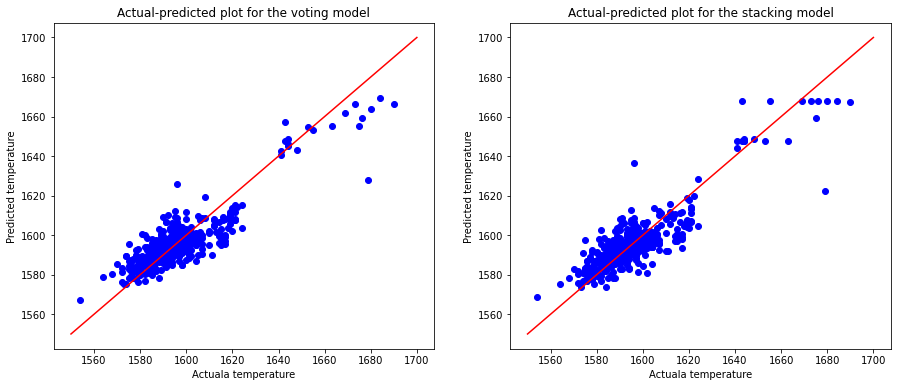

In [404]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].scatter(y_test, y_pred_voting_weighted, color='blue')
axes[0].plot([1550, 1700], [1550, 1700], color='red')
axes[0].set_xlabel('Actuala temperature')
axes[0].set_ylabel('Predicted temperature')
axes[0].set_title('Actual-predicted plot for the voting model')

axes[1].scatter(y_test, y_pred_stacking_opt, color='blue')
axes[1].plot([1550, 1700], [1550, 1700], color='red')
axes[1].set_xlabel('Actuala temperature')
axes[1].set_ylabel('Predicted temperature')
axes[1].set_title('Actual-predicted plot for the stacking model')
plt.show()

### Важность признаков

Важность признаков определим с помощью модели градиентонго бустинга.

In [414]:
lgbm_importance_final = pd.DataFrame({'feature': X_train_for_pipe.columns,
                                      'importance': lgbm['lgbmregressor'].feature_importances_}).sort_values('importance', ascending=False)

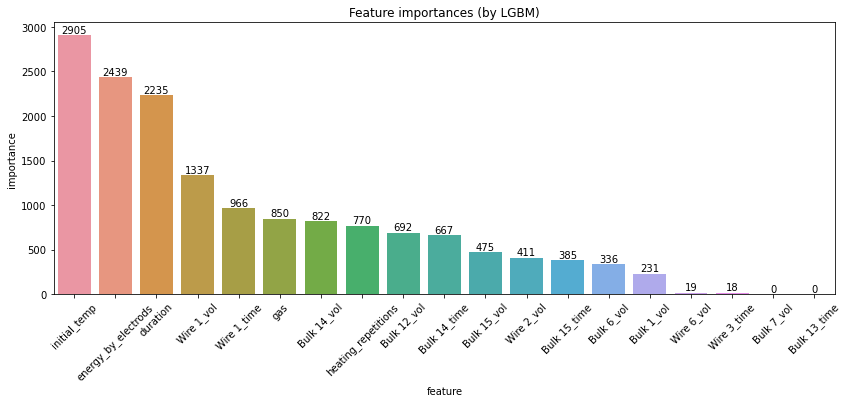

In [424]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=lgbm_importance_final, x='feature', y='importance')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title('Feature importances (by LGBM)')
plt.show()

- Наиболее важные признаки для модели градиентного бустинга - начальная температура, энергия, внесенная в сплав электродами и продолжительность процесса.
- Наиболее неважный признаки - время добавок Wire 3 и Bulk 13, а также объем добавок Wire 6 и Bulk 7.

# Отчет

## Сравнение с планом

1. Объединить все таблицы в одну по полям партий сплава и времени. - **Выполнено**. признаки добавлялись в таблицу по партии, а по времени вычищались те, что не попадали в момент замера.
2. Еще раз осмотреть данные, заполнить пропуски и вычистить аномалии. - **Выполнено**.
3. Выделить обучающую и тестовую выборки. - **Выполнено**.
4. Обучить несколько моделей, для каждой оптимизировать гиперпараметры, оценить качество на кросс-валидации. - **Выполнено**.

## Трудности и их решение

Самым сложным было выделить признаки, так как имелось множество таблиц и измерения, разнесенные во времени. Чтобы преодолеть это пришлось грамотно объединять таблицы, а также работать с форматом дата-время для обработки данных.

## Ключевые шаги решения задачи

Можно выделить следующие ключевые шаги решения задачи:
1. Ознакомление с данными и исследовательский анализ данных;
2. Формирование признакового пространства;
3. Предобработка данных и поиск аномалий;
4. Feature engineering, то есть отбор важных для решения задачи признаков;
5. Обучение моделей и оптимизация гиперпараметров;
6. Тестирование моделей и оценка производительности.

## Итоговая модель

В качестве финальной модели использовался Stacking Regressor - это один из методов ансамблирования, при котором предсказания моделей первого уровня являются признаками для модели второго уровня. В качестве моделей первого уровня использовались гребневая регрессия, случайный лес, метод К-ближайших соседей, метод опорных векторов, градиентный бустинг. В качестве модели второго уровня - градиентный бустинг.

Качество модели:
* MAE на кросс-валидации: 5.640
* МАЕ на тесте: 5.750
* МАРЕ на тесте: 0.004
* RMSE на тесте: 8.005
* R2 на тесте: 0.775